# Evaluating Fetal Well-being: Machine Learning Models for Cardiotocography Analysis and Prediction

# 1 Introduction


# 1 Introduction
Ever since its introduction in the seventies, **cardiotocography** has been the primary tool for assessing fetal conditions, aiming primarily to reduce perinatal mortality (between the 28th week of gestation and the first week of extrauterine life). CTG consists of two tracings:
1. the first depicting the fetal heart rate (FHR - Fetal Heart Rate)
2. while the second illustrates the presence, frequency, and intensity of the mother's uterine contractions.
Unfortunately, the analysis of cardiotocographic tracings is generally considered unreliable as the diagnoses provided depend on the personal and subjective interpretation of the operator reading the examination results. To properly and objectively utilize CTG readings, it is necessary to define an objective classification method for interpreting the tracings.

In this work, through the use of supervised machine learning techniques, the primary goal is to identify a model capable of discriminating, with the least possible error, cases where fetuses are problematic (or at risk) compared to regular situations. Secondly, given the presence of observations labeled as "suspicious," it is assumed that for such instances, experienced physicians were unable to discern the actual condition of the fetus, which would actually belong to either the "healthy" or "sick" class. It is therefore intended to define a binary classification model trained and optimized by excluding suspicious cases, ultimately proposing predictions on these instances considered unsupervised. Since the real labels are not available to test this last result, the prediction's validity will be validated in terms of robustness against classifications proposed by different algorithms.

# 2 Dataset Description
The dataset "Cardiotocography Data Set" has been extracted from the UCI Learning Repository and comprises 2126 fetal cardiotocograms (CTG) automatically processed by the SisPorto 2.0 system and classified by three expert obstetricians. The following 23 variables are described:

- LB: FHR baseline (beats per minute)
- AC: # accelerations of the fetal heart rate per second
- FM: # movements of the fetus per second
- UC: # uterine contractions per second
- DL: # mild decelerations of the fetal heart rate per second
- DS: # severe decelerations of the fetal heart rate per second
- DP: # prolonged decelerations of the fetal heart rate per second
- ASTV: percentage of time with abnormal short-term variability
- MSTV: mean value of short-term variability
- ALTV: percentage of time with abnormal long-term variability
- MLTV: mean value of long-term variability
- Width: amplitude of the FHR histogram
- Min: minimum value of the FHR histogram
- Max: maximum value of the FHR histogram
- Nmax: # peaks in the FHR histogram
- Nzeros: # zeros in the FHR histogram
- Mode: mode of the FHR histogram
- Mean: mean of the FHR histogram
- Median: median of the FHR histogram
- Variance: variance of the FHR histogram
- Tendency: trend of the FHR histogram
- CLASS: classification of the FHR pattern (code from 1 to 10)
- NSP: classification of the fetal state (N=Normal; S=Suspect; P=Pathological)

The variables are all numeric except for Tendency, CLASS, and NSP, which are categorical. The dataset has no missing values. For data import, it was necessary to reorganize the material provided by the UCI repository, removing superfluous information. The observations were randomly divided into training and test sets, containing 80% and 20% of the observations, respectively, while maintaining the original proportion of the NSP labels of interest for the application.

In [57]:
import pandas as pd

# I read the Excel file excluding the first row
dataset = pd.read_excel("CTG.xls", sheet_name="Raw Data")
dataset = dataset.iloc[1:]
dataset = dataset.iloc[:2126]

# I select only the columns of interest
columns = [
    'LB', 'AC', 'FM', 'UC', 'DL', 'DS', 'DP', 'ASTV', 'MSTV', 'ALTV', 'MLTV', 'Width', 'Min',
    'Max', 'Nmax', 'Nzeros', 'Mode', 'Mean', 'Median', 'Variance', 'Tendency', 'CLASS', 'NSP'
]

dataset = dataset[columns]

In [58]:
from sklearn.model_selection import train_test_split

# Specifico la colonna delle etichette NSP
labels = dataset["NSP"]

# Divido il dataset in training set (80%) e test set (20%), mantenendo la proporzione delle etichette NSP
train_set, test_set = train_test_split(dataset, test_size=0.2, stratify=labels, random_state=42)

# Salvo i due set in file separati
#train_set.to_csv("train_cardio.csv", index=False)
#test_set.to_csv("test_cardio.csv", index=False)

# 3 Data Pre-processing
## 3.1 Feature Selection
Given the high number of variables in the dataset, it is preferable to perform selection to eliminate superfluous or non-significant information for the analysis. First, the CLASS variable is removed, as it serves as an alternative to NSP and is applicable to a classification problem different from the current one. A study of the correlation between variables is conducted to remove features characterized by high correlation that would introduce redundant information.
Figure 1 shows the variables with the highest correlation. The "Mode" and "Median" features are removed, along with the "Min" feature, as it is excessively correlated with the "Mean" and "Width" variables, respectively.
To explore which variables may be less informative regarding discrimination in the classes of interest, boxplots of the numeric variables conditioned on the NSP variable classes were evaluated. Most features show different conditioned distributions, indicating good discriminatory ability. However, the "FM" (image 2), "Nzeros," and "DS" variables exhibit a collapsed distribution around zero regardless of the conditioning class; hence, they are removed from the dataset as they are degenerate and uninformative for classification purposes.

In [59]:
import pandas as pd

train_cardio = pd.read_csv("train_cardio.csv")
train_cardio_initial = train_cardio.copy()
# I eliminate the CLASS variable because it is an alternative to NSP that can be used in a classifcation problem other than the one at hand
train_cardio = train_cardio.drop(labels="CLASS", axis=1)

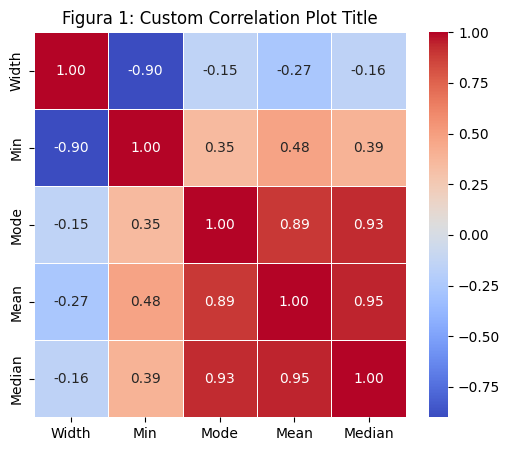

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
correlation_matrix = train_cardio[['Width', 'Min', 'Mode', 'Mean', 'Median']].corr()

# Set up the matplotlib figure
plt.figure(figsize=(6, 5))

# Create a heatmap using Seaborn
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)

# Set a custom title for the figure
plt.title("Figura 1: Custom Correlation Plot Title")

# Show the plot
plt.show()

In [61]:
# The "Mode" and "Median" features and the "Min" feature are removed as they are overly correlated with the "Mean" and "Width" variables, respectively.
train_cardio = train_cardio.drop(labels=["Mode", "Median", "Min"], axis=1)

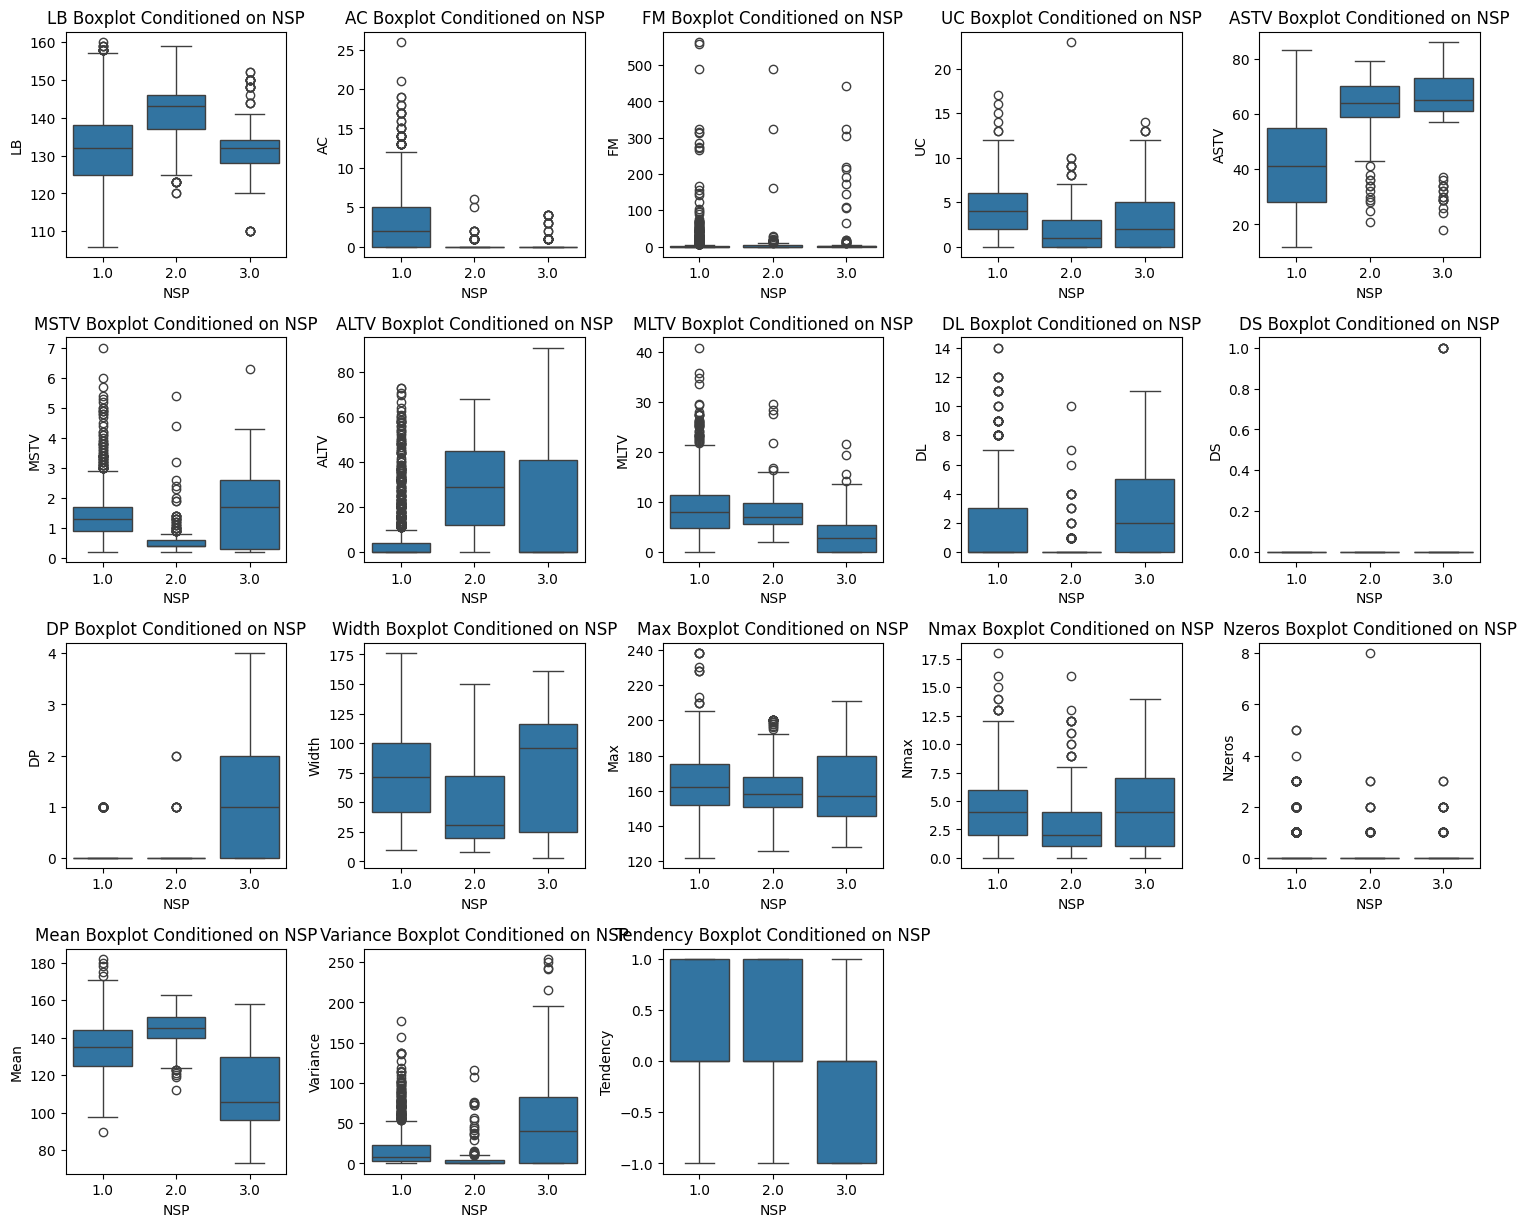

In [62]:
import matplotlib.pyplot as plt

# Select the necessary data subset
subset_df = train_cardio[['NSP', 'LB', 'AC', 'FM', 'UC', 'ASTV', 'MSTV', 'ALTV', 'MLTV',
                          'DL', 'DS', 'DP', 'Width', 'Max', 'Nmax', 'Nzeros',
                          'Mean', 'Variance', 'Tendency']]

# Display boxplots conditioned on the "NSP" classes for all numeric variables
plt.figure(figsize=(15, 15))
for i, col in enumerate(subset_df.columns[1:]):  # Exclude the 'NSP' column
    plt.subplot(5, 5, i + 1)
    sns.boxplot(x='NSP', y=col, data=subset_df)
    plt.title(f'{col} Boxplot Conditioned on NSP')
plt.tight_layout()
plt.show()

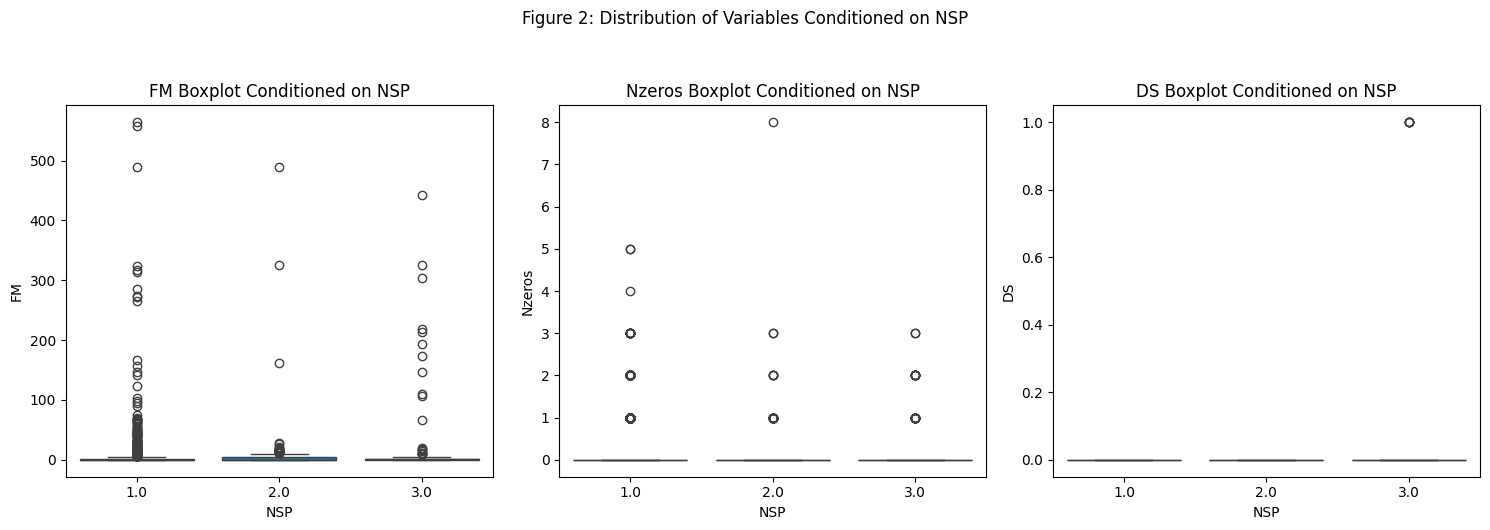

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select the necessary data subset
subset_df = train_cardio[['NSP', 'FM', 'Nzeros', 'DS']]

# Display boxplots conditioned on the "NSP" classes
plt.figure(figsize=(15, 5))
for i, col in enumerate(['FM', 'Nzeros', 'DS']):
    plt.subplot(1, 3, i+1)
    sns.boxplot(x='NSP', y=col, data=subset_df)
    plt.title(f'{col} Boxplot Conditioned on NSP')

plt.suptitle('Figure 2: Distribution of Variables Conditioned on NSP', y=1.05)
plt.tight_layout()
plt.show()

In [64]:
# Remove the variables "FM," "Nzeros," and "DS"
train_cardio = train_cardio.drop(['FM', 'Nzeros', 'DS'], axis=1)

## 3.2 Normalization
By conducting a study of feature variability using boxplots, it is evident that the units of measurement are inhomogeneous (image 3). In order to prevent features with higher ranges of variation from masking the information contained in the others, we proceed with normalization of all numerical variables in the range between 0 and 1 (image 4). Since the original features are already difficult to interpret (parameters of a plot), normalization does not result in particular losses in this respect.

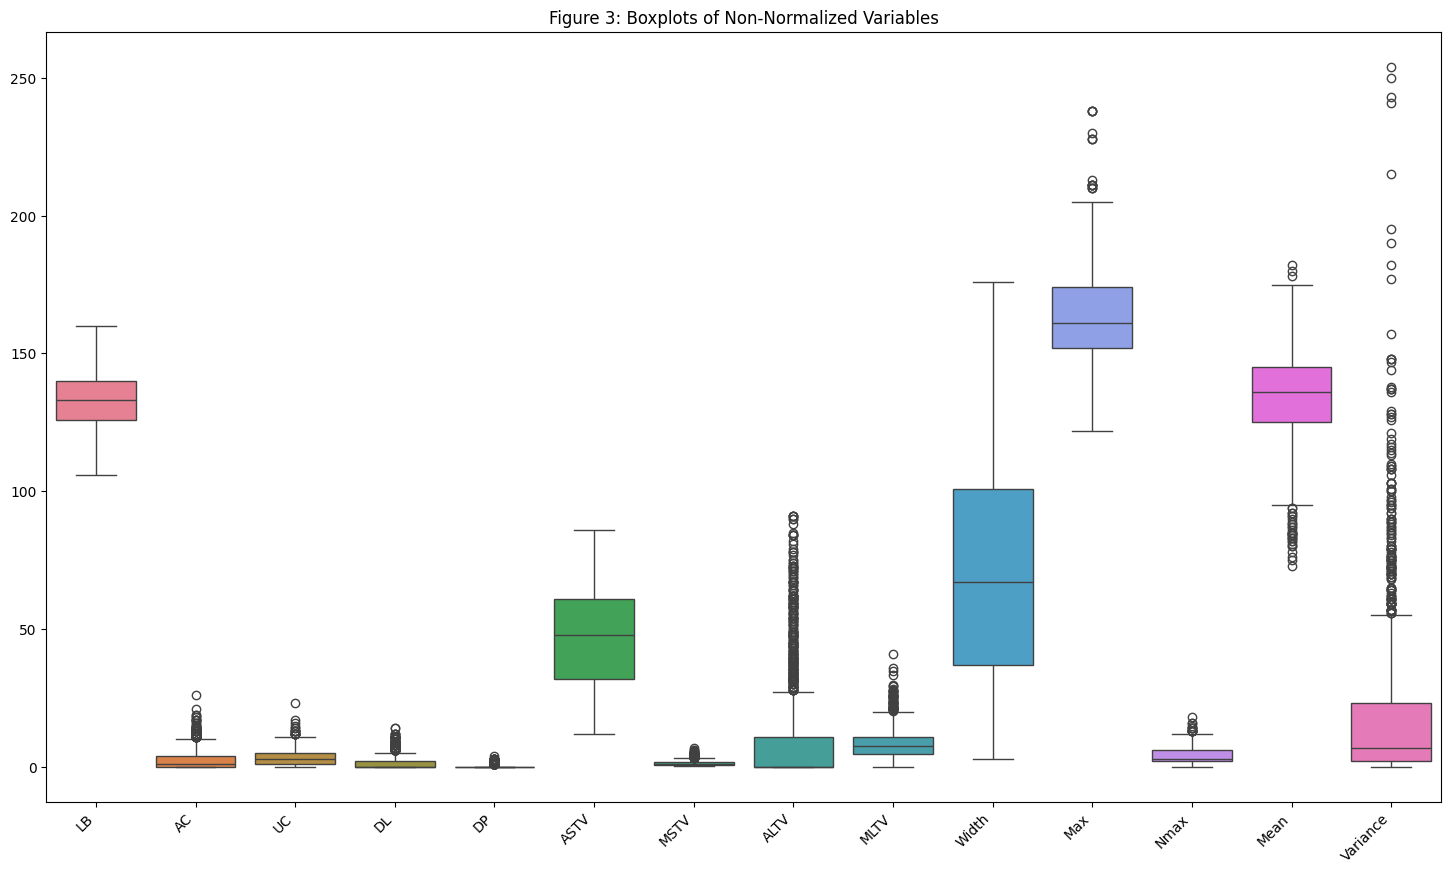

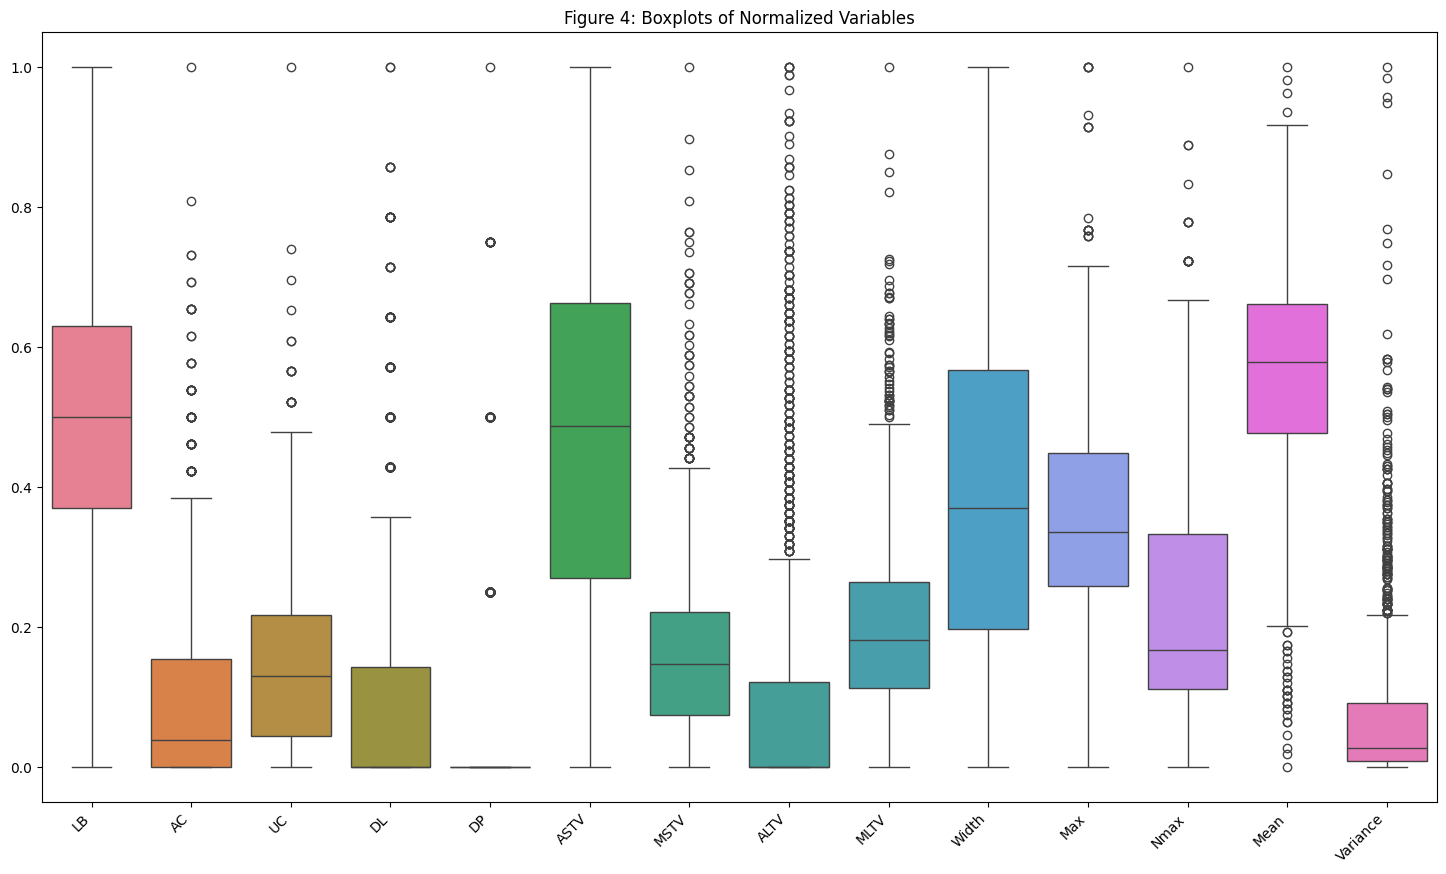

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Select only the numerical columns for boxplot analysis
numeric_columns = ['LB', 'AC', 'UC', 'DL', 'DP', 'ASTV', 'MSTV', 'ALTV', 'MLTV', 'Width',
       'Max', 'Nmax', 'Mean', 'Variance']

# Create a subset of the DataFrame containing only the numerical columns
subset_boxplot = train_cardio[numeric_columns]

# Display boxplots of non-normalized variables side by side
plt.figure(figsize=(18, 10))
sns.boxplot(data=subset_boxplot, orient='v')
plt.title('Figure 3: Boxplots of Non-Normalized Variables')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()

# Normalize the numerical columns
scaler = MinMaxScaler()
train_cardio[numeric_columns] = scaler.fit_transform(train_cardio[numeric_columns])

# Display boxplots of normalized variables side by side
plt.figure(figsize=(18, 10))
sns.boxplot(data=train_cardio[numeric_columns], orient='v')
plt.title('Figure 4: Boxplots of Normalized Variables')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()

## 3.3 Class Imbalance
Within the training set, the target variable NSP is strongly imbalanced, favoring observations labeled as "healthy" (78%) over the classes "suspect" (14%) and "pathological" (8%). In the application phase, this issue will be addressed by proposing models trained on rebalanced training sets through undersampling and oversampling techniques or by considering weight systems within various algorithms.

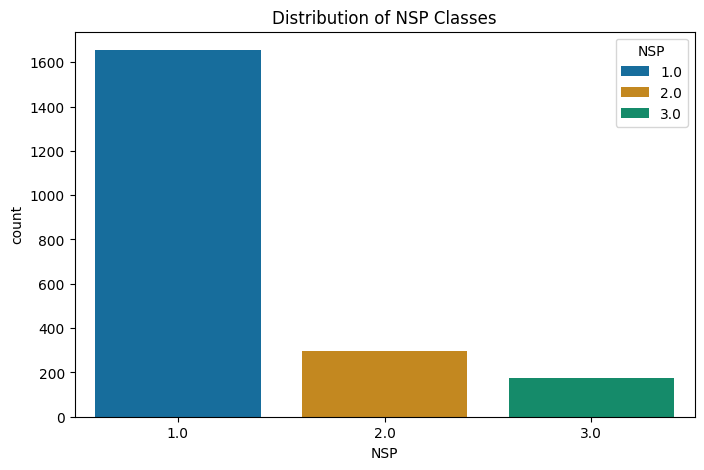

Percentage of HEALTHY cases:      77.84571966133585
Percentage of SUSPICIOUS cases:   13.8758231420508
Percentage of PATHOLOGICAL cases: 8.27845719661336


In [66]:
import seaborn as sns
import matplotlib.pyplot as plt

d1 = pd.read_csv("train_cardio.csv")
d2 = pd.read_csv("test_cardio.csv")
df = pd.concat([d1, d2], ignore_index=True)

# Display a barplot for the 'NSP' variable
plt.figure(figsize=(8, 5))
sns.countplot(x='NSP', data=df, palette='colorblind', hue='NSP')
plt.title('Distribution of NSP Classes')
plt.show()

# Print the percentage of HEALTHY, SUSPICIOUS, PATHOLOGICAL cases
print(f"Percentage of HEALTHY cases:      {((df['NSP'].values == 1.0).sum() / df['NSP'].size) * 100}")
print(f"Percentage of SUSPICIOUS cases:   {((df['NSP'].values == 2.0).sum() / df['NSP'].size) * 100}")
print(f"Percentage of PATHOLOGICAL cases: {((df['NSP'].values == 3.0).sum() / df['NSP'].size) * 100}")

# 4 Clustering and kernel pca.
For exploratory purposes, the aim is to verify whether applying **unsupervised clustering techniques** can identify well-defined groups of observations for subsequent comparison with real labels. The **k-means** and **kernel k-means** algorithms are considered in relation to potentially more informative subdivisions into k = 2 or k = 3 groups.


In [67]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Carica il dataset completo
dataset_completo = train_cardio.copy()

# Select the necessary columns for clustering and the actual labels
features = dataset_completo[['LB', 'AC', 'UC', 'DL', 'DP', 'ASTV', 'MSTV', 'ALTV', 'MLTV', 'Width', 'Max', 'Nmax', 'Mean', 'Variance', 'Tendency']]
etichette_reali = dataset_completo['NSP'] # Replace 'ActualLabels' with the name of your actual labels column

# Standardizzazione delle features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

In [68]:
from sklearn.cluster import KMeans

def plot_distribuzione_cluster(cluster_labels, etichette_reali, titolo):
    gruppi = sorted(etichette_reali.unique())
    result = pd.DataFrame(columns=["Gruppo", "Sani", "Sospetti", "Malati"])

    for cluster in set(cluster_labels):
        cluster_indices = (cluster_labels == cluster)
        etichette_cluster = etichette_reali[cluster_indices]

        # Conteggio di ciascun gruppo all'interno del cluster
        conteggi_gruppo = [etichette_cluster[etichette_cluster == gruppo].count() for gruppo in gruppi]

        # Aggiungi i conteggi al DataFrame usando loc
        result.loc[cluster] = ["Cluster " + str(cluster)] + conteggi_gruppo

    return result


In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.utils import check_random_state
from sklearn.decomposition import KernelPCA

# Classe KernelKMeans e LaplacianKernelKMeans
class KernelKMeans(BaseEstimator, ClusterMixin):
    """
    Kernel K-means

    Reference
    ---------
    Kernel k-means, Spectral Clustering and Normalized Cuts.
    Inderjit S. Dhillon, Yuqiang Guan, Brian Kulis.
    KDD 2004.
    """

    def __init__(self, n_clusters=3, max_iter=50, tol=1e-3, random_state=None,
                 kernel="linear", gamma=None, degree=3, coef0=1,
                 kernel_params=None, verbose=0):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        self.kernel = kernel
        self.gamma = gamma
        self.degree = degree
        self.coef0 = coef0
        self.kernel_params = kernel_params
        self.verbose = verbose

    @property
    def _pairwise(self):
        return self.kernel == "precomputed"

    def _get_kernel(self, X, Y=None):
        if callable(self.kernel):
            params = self.kernel_params or {}
        else:
            params = {"gamma": self.gamma,
                      "degree": self.degree,
                      "coef0": self.coef0}
        return pairwise_kernels(X, Y, metric=self.kernel,
                                filter_params=True, **params)

    def fit(self, X, y=None, sample_weight=None):
        n_samples = X.shape[0]

        K = self._get_kernel(X)

        sw = sample_weight if sample_weight else np.ones(n_samples)
        self.sample_weight_ = sw

        rs = check_random_state(self.random_state)
        self.labels_ = rs.randint(self.n_clusters, size=n_samples)

        dist = np.zeros((n_samples, self.n_clusters))
        self.within_distances_ = np.zeros(self.n_clusters)

        for it in range(self.max_iter):
            dist.fill(0)
            self._compute_dist(K, dist, self.within_distances_,
                               update_within=True)
            labels_old = self.labels_
            self.labels_ = dist.argmin(axis=1)

            # Compute the number of samples whose cluster did not change
            # since the last iteration.
            n_same = np.sum((self.labels_ - labels_old) == 0)
            if 1 - float(n_same) / n_samples < self.tol:
                if self.verbose:
                    print("Converged at iteration", it + 1)
                break

        self.X_fit_ = X

        return self

    def _compute_dist(self, K, dist, within_distances, update_within):
        """Compute an n_samples x n_clusters distance matrix using the
        kernel trick."""
        sw = self.sample_weight_

        for j in range(self.n_clusters):
            mask = self.labels_ == j

            if np.sum(mask) == 0:
                raise ValueError("Empty cluster found, try smaller n_cluster.")

            denom = sw[mask].sum()
            denomsq = denom * denom

            if update_within:
                KK = K[mask][:, mask]  # K[mask, mask] does not work.
                dist_j = np.sum(np.outer(sw[mask], sw[mask]) * KK / denomsq)
                within_distances[j] = dist_j
                dist[:, j] += dist_j
            else:
                dist[:, j] += within_distances[j]

            dist[:, j] -= 2 * np.sum(sw[mask] * K[:, mask], axis=1) / denom

    def fit_predict(self, X, y=None):
        self.fit(X)
        return self.labels_

class LaplacianKernelKMeans(KernelKMeans):
    def _get_kernel(self, X, Y=None):
        if self.kernel == "laplacian":
            # Per il kernel laplaciano, usiamo direttamente il kernel 'laplacian'
            # disponibile in sklearn
            return pairwise_kernels(X, Y, metric="laplacian", gamma=self.gamma)
        else:
            # Usa il kernel specificato
            return super()._get_kernel(X, Y)

    def predict(self, X):
        K = self._get_kernel(X, self.X_fit_)
        n_samples = X.shape[0]
        dist = np.zeros((n_samples, self.n_clusters))
        self._compute_dist(K, dist, self.within_distances_,
                           update_within=False)
        return dist.argmin(axis=1)

# Funzione per visualizzare la distribuzione delle etichette reali nei cluster
def plot_distribuzione_cluster_with_plot(labels_cluster, labels_reali, title, nrtable = None):
    # Converti labels_reali in categorie Sani/Sospetti/Malati se necessario
    unique_labels = np.unique(labels_reali)
    if len(unique_labels) == 3:
        mapping = {min(unique_labels): 'Sani',
                sorted(unique_labels)[1]: 'Sospetti',
                max(unique_labels): 'Malati'}
        labels_reali_cat = np.array([mapping[l] for l in labels_reali])
    else:
        labels_reali_cat = labels_reali

    # Crea un DataFrame con i risultati
    results = pd.DataFrame({
        'Cluster': labels_cluster,
        'Etichetta': labels_reali_cat
    })

    # Crea tabella di contingenza
    contingency = pd.crosstab(results['Cluster'], results['Etichetta'])

    # Visualizza la tabella
    value_print = "Distribuzione delle etichette reali nei cluster:"
    if nrtable is not None:
        value_print = f"Tabella {nrtable} - {value_print}"
    print(f"\n{value_print}")
    print(contingency)


    # Crea il grafico a barre
    plt.figure(figsize=(10, 6))

    # Per ogni cluster, mostra la distribuzione delle etichette reali
    ax = contingency.plot(kind='bar', stacked=True)

    plt.title(title)
    plt.xlabel('Cluster')
    plt.ylabel('Numero di osservazioni')
    plt.legend(title='Etichetta reale')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

    return contingency

In [70]:
# Esempio di utilizzo con k-means e k=2
kmeans_model_2 = KMeans(n_clusters=2, random_state=42, n_init=10)
labels_kmeans_2 = kmeans_model_2.fit_predict(X_scaled)
risultato_kmeans_2 = plot_distribuzione_cluster(labels_kmeans_2, etichette_reali,
                                                'Distribution of real labels in clusters (k-means, k=2)')

# Esempio di utilizzo con k-means e k=3
kmeans_model_3 = KMeans(n_clusters=3, random_state=42, n_init=10)
labels_kmeans_3 = kmeans_model_3.fit_predict(X_scaled)
risultato_kmeans_3 = plot_distribuzione_cluster(labels_kmeans_3, etichette_reali,
                                                'Distribution of real labels in clusters (k-means, k=3)')

# Show results for all methods
print("Results for k-means with k=2:")
print(risultato_kmeans_2)

print("\nResults for k-means with k=3:")
print(risultato_kmeans_3)

Results for k-means with k=2:
      Gruppo  Sani  Sospetti  Malati
0  Cluster 0   515        20      87
1  Cluster 1   808       216      54

Results for k-means with k=3:
      Gruppo  Sani  Sospetti  Malati
0  Cluster 0   198       192      53
1  Cluster 1   847        31       2
2  Cluster 2   278        13      86
Results for k-means with k=2:
      Gruppo  Sani  Sospetti  Malati
0  Cluster 0   515        20      87
1  Cluster 1   808       216      54

Results for k-means with k=3:
      Gruppo  Sani  Sospetti  Malati
0  Cluster 0   198       192      53
1  Cluster 1   847        31       2
2  Cluster 2   278        13      86


Gamma: 0.000010, Silhouette Score: 0.1424
Gamma: 0.000100, Silhouette Score: 0.1417
Gamma: 0.001000, Silhouette Score: 0.1417
Gamma: 0.010000, Silhouette Score: 0.1406
Gamma: 0.100000, Silhouette Score: 0.1187
Gamma: 1.000000, Silhouette Score: -0.0108
Gamma: 10.000000, Silhouette Score: -0.0120
Gamma: 100.000000, Silhouette Score: -0.0120

Miglior valore di gamma: 1e-05
Converged at iteration 34

Tabella 1 - Distribuzione delle etichette reali nei cluster:
Etichetta  Malati  Sani  Sospetti
Cluster                          
0              53   216       199
1              86   339        14
2               2   768        23


<Figure size 1000x600 with 0 Axes>

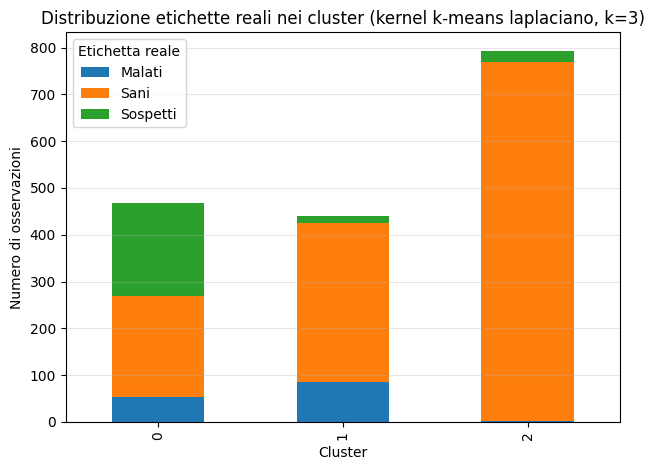

Gamma: 0.000010, Silhouette Score: 0.1424
Gamma: 0.000100, Silhouette Score: 0.1417
Gamma: 0.001000, Silhouette Score: 0.1417
Gamma: 0.010000, Silhouette Score: 0.1406
Gamma: 0.100000, Silhouette Score: 0.1187
Gamma: 1.000000, Silhouette Score: -0.0108
Gamma: 10.000000, Silhouette Score: -0.0120
Gamma: 100.000000, Silhouette Score: -0.0120

Miglior valore di gamma: 1e-05
Converged at iteration 34

Tabella 1 - Distribuzione delle etichette reali nei cluster:
Etichetta  Malati  Sani  Sospetti
Cluster                          
0              53   216       199
1              86   339        14
2               2   768        23


<Figure size 1000x600 with 0 Axes>

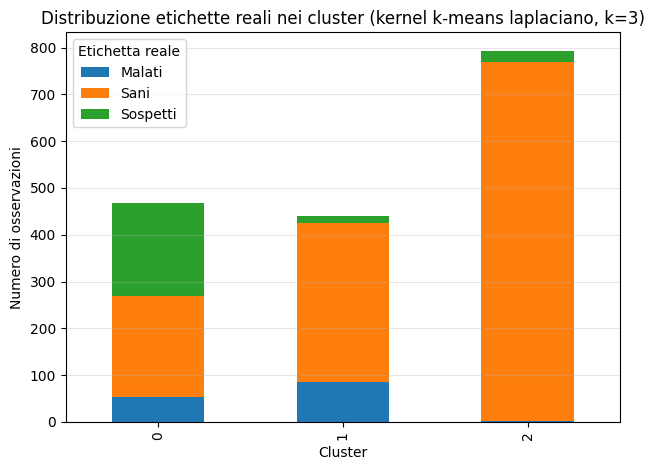

In [71]:
# Trova automaticamente il miglior valore di gamma
from sklearn.metrics import silhouette_score

gamma_values = np.logspace(-5, 2, 8)
best_score = -1
best_gamma = None

for gamma in gamma_values:
    model = LaplacianKernelKMeans(n_clusters=3, max_iter=100, random_state=42,
                                 kernel="laplacian", gamma=gamma, verbose=0)
    labels = model.fit_predict(X_scaled)

    try:
        score = silhouette_score(X_scaled, labels)
        print(f"Gamma: {gamma:.6f}, Silhouette Score: {score:.4f}")

        if score > best_score:
            best_score = score
            best_gamma = gamma
    except:
        print(f"Gamma: {gamma:.6f} - Errore nel calcolo dello score")

print(f"\nMiglior valore di gamma: {best_gamma}")

# Utilizza il kernel k-means con il miglior gamma
kernel_kmeans = LaplacianKernelKMeans(n_clusters=3, max_iter=100, random_state=42,
                                      kernel="laplacian", gamma=best_gamma, verbose=1)
cluster_labels = kernel_kmeans.fit_predict(X_scaled)

# Visualizza i risultati
risultato = plot_distribuzione_cluster_with_plot(cluster_labels, etichette_reali,
                                      'Distribuzione etichette reali nei cluster (kernel k-means laplaciano, k=3)', 1)

In general, the results obtained by evaluating different configurations of the hyperparameters do not show consistency with respect to the actual labels. The only informative result is obtained using kk-m with Laplacian kernel, k = 3, the results of which are shown in Table 1. Groups 0 and 1 have observations belonging to each class, while group 2 appears to have the fewest instances belonging to the sick class.
 This result suggests that healthy fetuses are characterized by three different typical CTG trends, such that in one case (the most represented) the fetus is well discriminated from pathological situations. To study the obtained result graphically, we reduce the dimensionality of the dataset by kernel pca with kernel rbf.

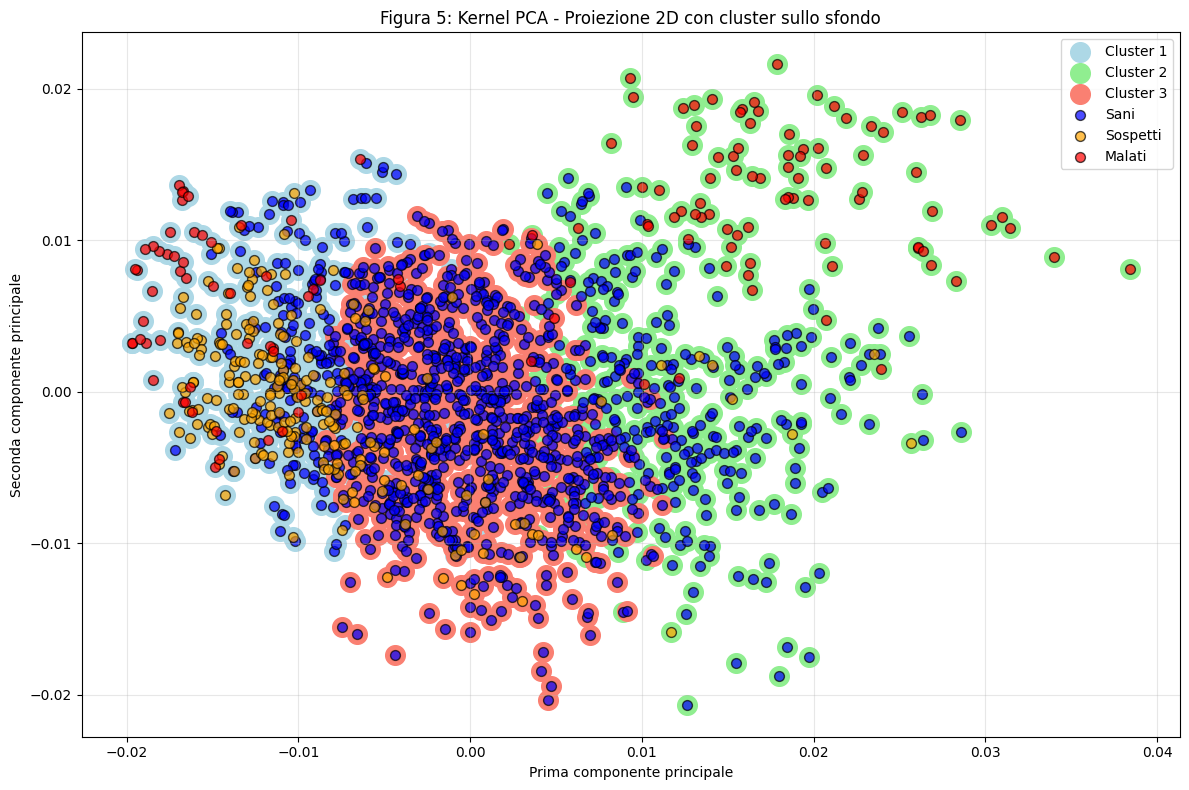

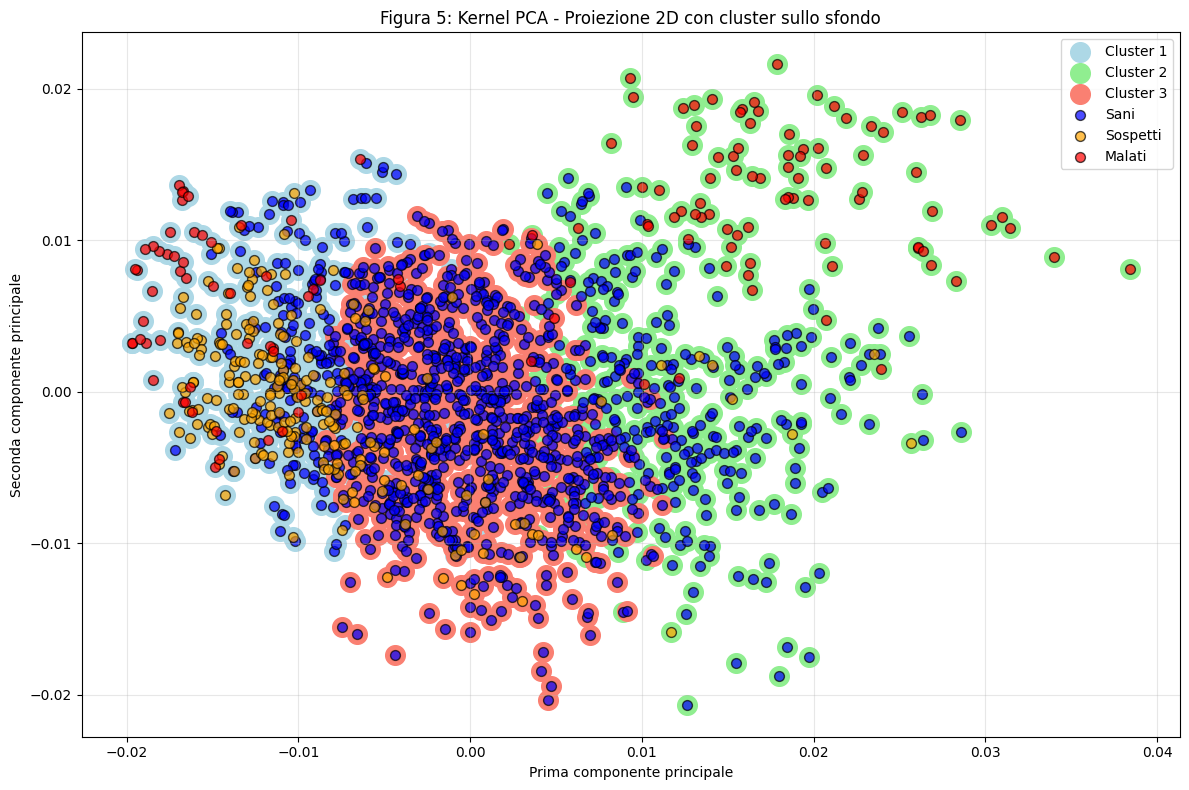

In [72]:
# Visualizzazione con kernel PCA
# Utilizzo un rbf (Gaussian) kernel che è simile al laplaciano ma supportato da KernelPCA
kpca = KernelPCA(n_components=2, kernel='rbf', gamma=best_gamma)
X_kpca = kpca.fit_transform(X_scaled)

# Creazione del grafico
plt.figure(figsize=(12, 8))

# Visualizzazione dei cluster con aree colorate sullo sfondo
cluster_colors = ['lightblue', 'lightgreen', 'salmon']
for i, cluster_id in enumerate(np.unique(cluster_labels)):
    cluster_points = X_kpca[cluster_labels == cluster_id]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1],
                c=cluster_colors[i], alpha=1.0, s=200, label=f'Cluster {cluster_id+1}')

# Crea nomi delle etichette reali
if len(np.unique(etichette_reali)) == 3:
    mapping = {min(np.unique(etichette_reali)): 'Sani',
           sorted(np.unique(etichette_reali))[1]: 'Sospetti',
           max(np.unique(etichette_reali)): 'Malati'}
    color_map = {'Sani': 'blue', 'Sospetti': 'orange', 'Malati': 'red'}

    # Plot dei punti con colori basati sulle etichette reali
    for label_value, label_name in mapping.items():
        class_mask = etichette_reali == label_value
        plt.scatter(
            X_kpca[class_mask, 0], X_kpca[class_mask, 1],
            c=color_map[label_name],
            label=label_name,
            edgecolors='k', alpha=0.7, s=50
        )
else:
    # Nel caso le etichette non siano numeriche
    color_map = {'Sani': 'blue', 'Sospetti': 'orange', 'Malati': 'red'}
    for label in np.unique(etichette_reali):
        class_mask = etichette_reali == label
        plt.scatter(
            X_kpca[class_mask, 0], X_kpca[class_mask, 1],
            label=label,
            edgecolors='k', alpha=0.7, s=50
        )

plt.title('Figura 5: Kernel PCA - Proiezione 2D con cluster sullo sfondo')
plt.xlabel('Prima componente principale')
plt.ylabel('Seconda componente principale')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Figure 5 shows the projection of instances on the first two components with their respective labels.
It is observed that diseased fetuses are concentrated in two areas located within separate clusters. This result can be interpreted as the presence of two different pathological situations characterized by different CTG patterns.
Given the high presence of uncertain cases in the left cluster, it can be assumed that the corresponding pathological condition is more difficult to diagnose than the one contained on the right. Focusing on the suspicious cases, it can be seen that apart from the concentration on the left, there are scattered observations in all groups.

It is suspected that these observations, instead of constituting a well-defined class, may actually be healthy or diseased fetuses that the medical expert failed to classify. This possibility will be evaluated later in relation to the results obtained from the classification.

# 5 Classification.
In a classification context, several tools were applied, evaluating their performance (over all generalization error) through a 10-fold Cross Validation strategy taking care to use the same folds as the classifier varied.
The tools used were K-nearest neighbors (KNN), Random Forest (RF) and Support Vector Machine (SVM) for which several variants were evaluated to account for the class imbalance problem, including estimating models on balanced training sets through undersampling and oversampling techniques. The various techniques mentioned above will be presented below, briefly indicating hyperparameter optimization strategies.

In [73]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
# Definisco i fold da poi usare per tutti i classificatori
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
# DataFrame per i risultati sul training set
results_df_training_set = pd.DataFrame(columns=["Method", "Accuracy", "Specificity1", "Sensitivity3"])

The following procedure is followed for each of the K-fold :
1. A model is trained using K-1 of the folds as training data
2. The resulting model is validated on the remaining part of the data.

In [74]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

# Define X_train and y_train
columns = ['LB', 'AC', 'UC', 'DL', 'DP', 'ASTV', 'MSTV', 'ALTV', 'MLTV', 'Width',
       'Max', 'Nmax', 'Mean', 'Variance', 'Tendency']
X_train = train_cardio[columns]
y_train = train_cardio['NSP']

# Define the oversampler and undersampler
oversampler = RandomOverSampler(random_state=42)
undersampler = RandomUnderSampler(random_state=42)

# Apply oversampling
X_train_oversampled, y_train_oversampled = oversampler.fit_resample(X_train, y_train)

# Apply undersampling
X_train_undersampled, y_train_undersampled = undersampler.fit_resample(X_train, y_train)

/Users/lorenzodefeo/Desktop/Python/Evaluating-Fetal-Well-being-Machine-Learning-Models-for-Cardiotocography-Analysis-and-Prediction/venv/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/lorenzodefeo/Desktop/Python/Evaluating-Fetal-Well-being-Machine-Learning-Models-for-Cardiotocography-Analysis-and-Prediction/venv/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/Users/lorenzodefeo/Desktop/Python/Evaluating-Fetal-Well-being-Machine-Learning-Models-for-Cardiotocography-Analysis-and-Prediction/venv/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed 

## 5.1 K-nearest Neighbor
The nonparametric KNN algorithm requires setting a hyperparameter k that defines the number of points closest to the i-th data point that contribute to its classification. The selection of this parameter was conducted through a 10-fold Cross Validation, evaluating all possible values between 1 and 30. Next, the results obtained in terms as k varies are reported.

In [75]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, confusion_matrix

def plot_cross_validation_results(k_values, accuracy_scores, best_k, best_accuracy):
    """
    Plot the results of cross-validation for different values of k.

    Parameters:
    - k_values (array): Array of k values.
    - accuracy_scores (array): Array of accuracy scores for corresponding k values.
    - best_k (int): Best k value selected during cross-validation.
    - best_accuracy (float): Accuracy corresponding to the best k value.
    """

    plt.figure(figsize=(10, 6))
    plt.plot(k_values, accuracy_scores, marker='o', linestyle='-', color='b')
    plt.title('Hyperparameter k evaluation by Cross Validation')
    plt.xlabel('Number of neighbors (k)')
    plt.ylabel('Accuracy')
    plt.xticks(k_values)
    plt.axvline(x=best_k, color='r', linestyle='--', label=f'Best k: {best_k}\nAccuracy: {best_accuracy:.4f}')
    plt.legend()
    plt.show()

def find_accuracy_scores(k_values, X_train, y_train):
    # Inizializza la lista per salvare gli score di accuracy
    accuracy_scores = []
    for k in k_values:
        knn_model = KNeighborsClassifier(n_neighbors=k)
        y_train_pred = cross_val_predict(knn_model, X_train, y_train, cv=10)

        # Calcola l'accuracy
        acc_score = accuracy_score(y_train, y_train_pred)

        # Salva l'accuracy
        accuracy_scores.append(acc_score)
    return accuracy_scores

def calculate_performance(conf_matrix):
    true_positive_class1 = conf_matrix[0,0]
    false_positive_class1 = conf_matrix[0,1] + conf_matrix[0,2]
    true_negative_class1 = conf_matrix[1,1] + conf_matrix[2,2]
    false_negative_class1 = conf_matrix[1,0] + conf_matrix[2,0]
    sensitivity_class1 = true_positive_class1 / (true_positive_class1 + false_negative_class1)
    specificity_class1 = true_negative_class1 / (true_negative_class1 + false_positive_class1)
    accuracy_class1 = (true_positive_class1 + true_negative_class1) / (true_positive_class1 + true_negative_class1 + false_positive_class1 + false_negative_class1)

    # Calcola i valori per la classe 3
    true_positive_class3 = conf_matrix[2,2]
    false_positive_class3 = conf_matrix[2,0] + conf_matrix[2,1]
    true_negative_class3 = conf_matrix[0,0] + conf_matrix[1,1]
    false_negative_class3 = conf_matrix[0,2] + conf_matrix[1,2]

    # Sensitivity, Specificity e Accuracy per la classe 3
    sensitivity_class3 = true_positive_class3 / (true_positive_class3 + false_negative_class3)
    specificity_class3 = true_negative_class3 / (true_negative_class3 + false_positive_class3)
    accuracy_class3 = (true_positive_class3 + true_negative_class3) / (true_positive_class3 + true_negative_class3 + false_positive_class3 + false_negative_class3)

    return {
        "Accuracy": accuracy_class1,
        "Specificity1": specificity_class1,
        "Sensitivity3": sensitivity_class3
    }


# Funzioni personalizzate per calcolare accuracy, specificity e sensitivity
def calculate_accuracy(y_true, y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred)
    true_positive_class1 = conf_matrix[0,0]
    false_positive_class1 = conf_matrix[0,1] + conf_matrix[0,2]
    true_negative_class1 = conf_matrix[1,1] + conf_matrix[2,2]
    false_negative_class1 = conf_matrix[1,0] + conf_matrix[2,0]
    sensitivity_class1 = true_positive_class1 / (true_positive_class1 + false_negative_class1)
    specificity_class1 = true_negative_class1 / (true_negative_class1 + false_positive_class1)
    accuracy_class1 = (true_positive_class1 + true_negative_class1) / (true_positive_class1 + true_negative_class1 + false_positive_class1 + false_negative_class1)

    return accuracy_class1

def calculate_specificity(y_true, y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred)
    true_positive_class1 = conf_matrix[0,0]
    false_positive_class1 = conf_matrix[0,1] + conf_matrix[0,2]
    true_negative_class1 = conf_matrix[1,1] + conf_matrix[2,2]
    false_negative_class1 = conf_matrix[1,0] + conf_matrix[2,0]
    sensitivity_class1 = true_positive_class1 / (true_positive_class1 + false_negative_class1)
    specificity_class1 = true_negative_class1 / (true_negative_class1 + false_positive_class1)
    accuracy_class1 = (true_positive_class1 + true_negative_class1) / (true_positive_class1 + true_negative_class1 + false_positive_class1 + false_negative_class1)

    return specificity_class1

def calculate_sensitivity(y_true, y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred)
    true_positive_class3 = conf_matrix[2,2]
    false_positive_class3 = conf_matrix[2,0] + conf_matrix[2,1]
    true_negative_class3 = conf_matrix[0,0] + conf_matrix[1,1]
    false_negative_class3 = conf_matrix[0,2] + conf_matrix[1,2]

    # Sensitivity, Specificity e Accuracy per la classe 3
    sensitivity_class3 = true_positive_class3 / (true_positive_class3 + false_negative_class3)
    specificity_class3 = true_negative_class3 / (true_negative_class3 + false_positive_class3)
    accuracy_class3 = (true_positive_class3 + true_negative_class3) / (true_positive_class3 + true_negative_class3 + false_positive_class3 + false_negative_class3)

    return sensitivity_class3

### 5.1.1 KNN: Case with unbalanced data

In [76]:
from knn_optimizer import KNNOptimizer

<Figure size 640x480 with 0 Axes>

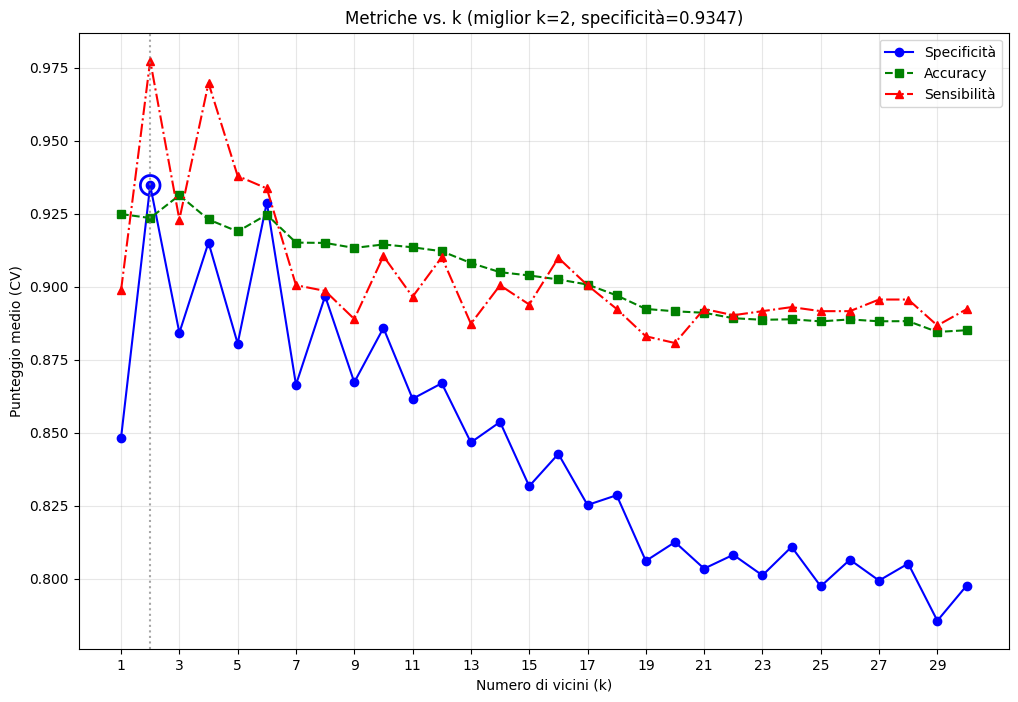

Miglior valore di k: 2, Miglior specificity: 0.9347
Con k = 2: Accuracy = 0.9235, Specificità = 0.9347, Sensibilità = 0.9774
Come suggerisce il grafico, il miglior risultato per specificity si ottiene con k = 2.

Metriche del modello ottimizzato per specificity:
Accuracy: 0.9235250445447291
Specificità: 0.9347271205497011
Sensibilità: 0.9773809523809524


<Figure size 640x480 with 0 Axes>

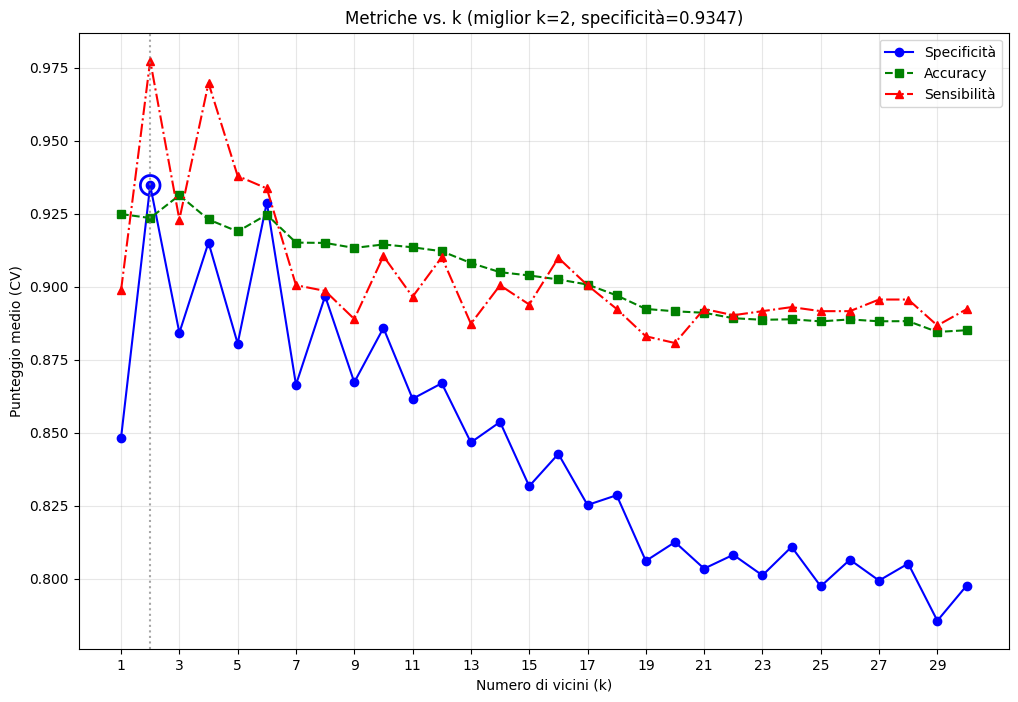

Miglior valore di k: 2, Miglior specificity: 0.9347
Con k = 2: Accuracy = 0.9235, Specificità = 0.9347, Sensibilità = 0.9774
Come suggerisce il grafico, il miglior risultato per specificity si ottiene con k = 2.

Metriche del modello ottimizzato per specificity:
Accuracy: 0.9235250445447291
Specificità: 0.9347271205497011
Sensibilità: 0.9773809523809524


In [77]:
# Uso della classe KNNOptimizer, con dataset NON SBILANCIATO
knn_opt = KNNOptimizer()

# Run optimization
knn_opt.optimize(
    X_train,
    y_train,
    k_range=range(1, 31),
    cv=cv,
    optimization_metric='specificity',
    calculate_accuracy=calculate_accuracy,
    calculate_specificity=calculate_specificity,
    calculate_sensitivity=calculate_sensitivity
)

# Plot the metrics
plt.figure()
knn_opt.plot_metrics()
plt.show()

# Print optimization results
knn_opt.print_results()

# Cross-validate the best model
knn_opt.cross_validate_best_model(
    X_train,
    y_train,
    cv=cv,
    calculate_accuracy=calculate_accuracy,
    calculate_specificity=calculate_specificity,
    calculate_sensitivity=calculate_sensitivity
)

# Print cross-validation results
knn_opt.print_cv_results()

# Add results to your DataFrame
results_df_training_set.loc[len(results_df_training_set)] = knn_opt.get_results_for_dataframe()

# To make predictions with the best model
#knn_opt.fit(X_train, y_train)
#y_pred = knn_opt.predict(X_test)

Based on the best k parameter found, I evaluate performance, which was evaluated in terms of accuracy, class specificity of the healthy (vs. others) and sensitivity of the sick.

### 5.1.1 KNN: Case with Oversampling data

<Figure size 640x480 with 0 Axes>

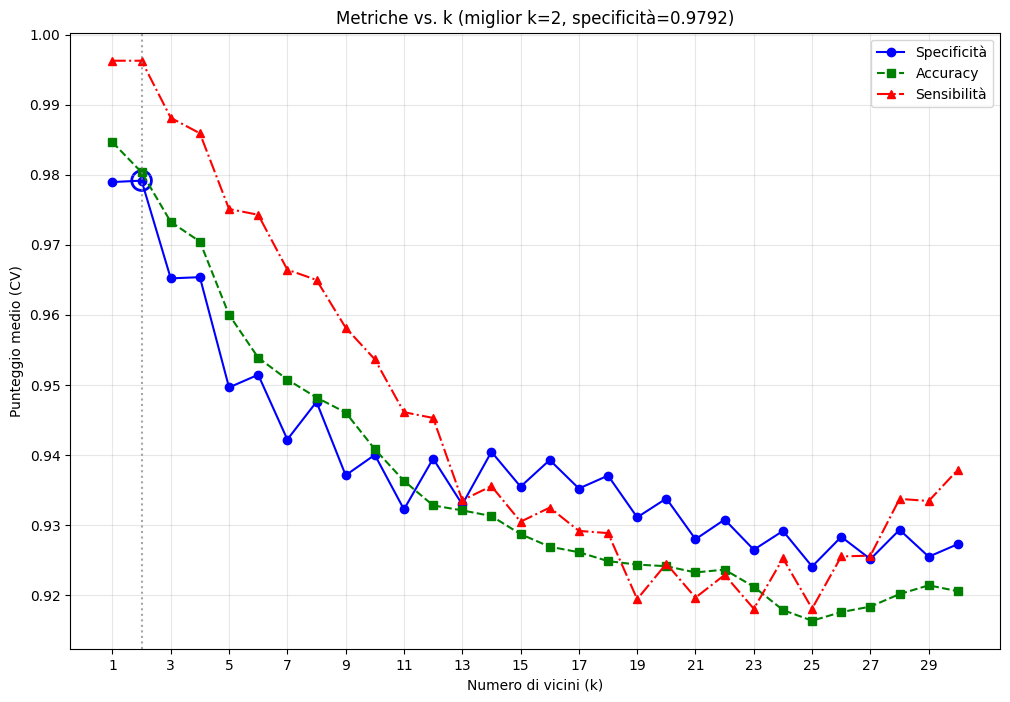

Miglior valore di k: 2, Miglior specificity: 0.9792
Con k = 2: Accuracy = 0.9803, Specificità = 0.9792, Sensibilità = 0.9963
Come suggerisce il grafico, il miglior risultato per specificity si ottiene con k = 2.

Metriche del modello ottimizzato per specificity:
Accuracy: 0.9803430874764931
Specificità: 0.9791530048673852
Sensibilità: 0.9962630456738861


<Figure size 640x480 with 0 Axes>

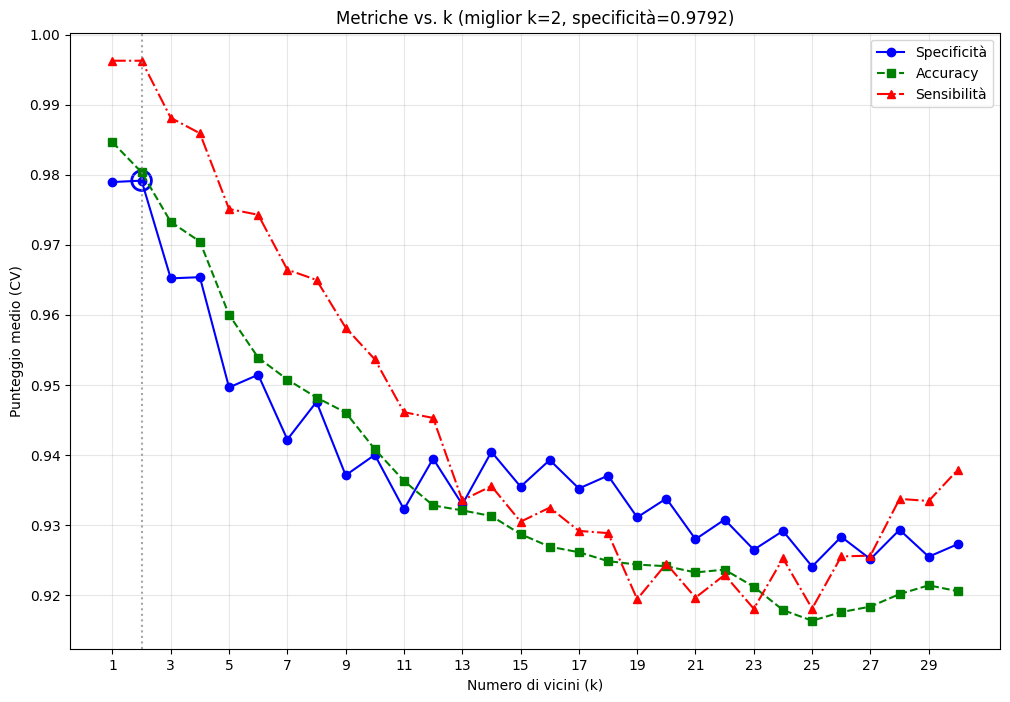

Miglior valore di k: 2, Miglior specificity: 0.9792
Con k = 2: Accuracy = 0.9803, Specificità = 0.9792, Sensibilità = 0.9963
Come suggerisce il grafico, il miglior risultato per specificity si ottiene con k = 2.

Metriche del modello ottimizzato per specificity:
Accuracy: 0.9803430874764931
Specificità: 0.9791530048673852
Sensibilità: 0.9962630456738861


In [78]:
knn_opt_oversampling = KNNOptimizer()

# Run optimization
knn_opt_oversampling.optimize(
    X_train_oversampled,
    y_train_oversampled,
    k_range=range(1, 31),
    cv=cv,
    optimization_metric='specificity',
    calculate_accuracy=calculate_accuracy,
    calculate_specificity=calculate_specificity,
    calculate_sensitivity=calculate_sensitivity
)

# Plot the metrics
plt.figure()
knn_opt_oversampling.plot_metrics()
plt.show()

# Print optimization results
knn_opt_oversampling.print_results()

# Cross-validate the best model
knn_opt_oversampling.cross_validate_best_model(
    X_train_oversampled,
    y_train_oversampled,
    cv=cv,
    calculate_accuracy=calculate_accuracy,
    calculate_specificity=calculate_specificity,
    calculate_sensitivity=calculate_sensitivity
)

# Print cross-validation results
knn_opt_oversampling.print_cv_results()

# Add results to your DataFrame
results_df_training_set.loc[len(results_df_training_set)] = knn_opt_oversampling.get_results_for_dataframe(type_data='Oversampling')

# To make predictions with the best model
#knn_opt_oversampling.fit(X_train, y_train)
#y_pred = knn_opt_oversampling.predict(X_test)

### 5.1.1 KNN: Case with Undersampling data

<Figure size 640x480 with 0 Axes>

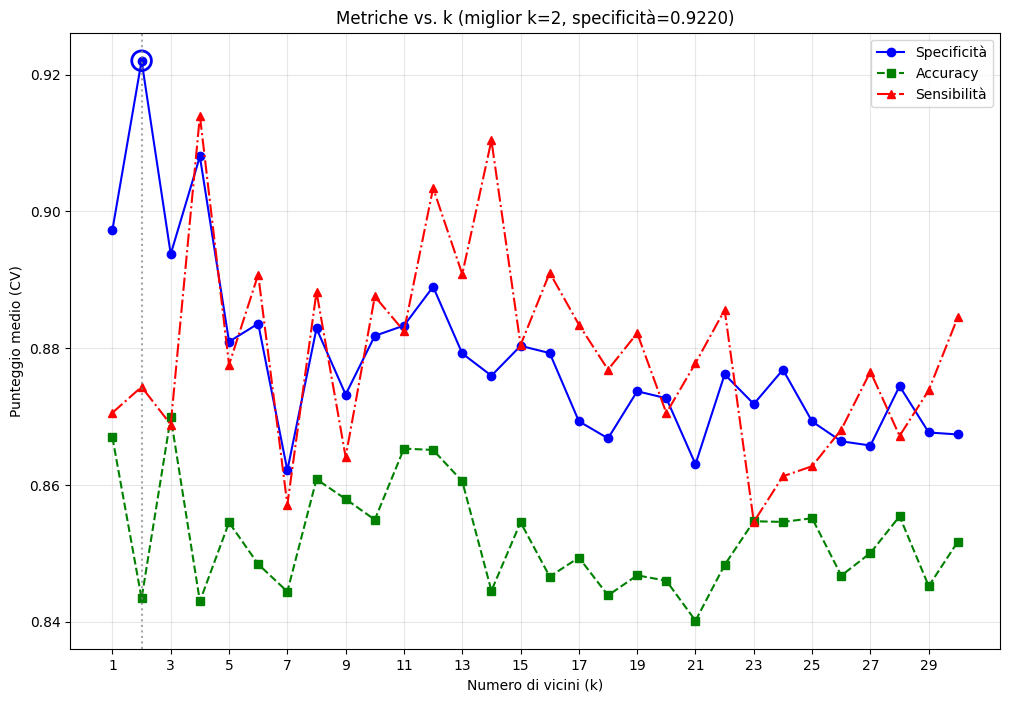

Miglior valore di k: 2, Miglior specificity: 0.9220
Con k = 2: Accuracy = 0.8434, Specificità = 0.9220, Sensibilità = 0.8743
Come suggerisce il grafico, il miglior risultato per specificity si ottiene con k = 2.

Metriche del modello ottimizzato per specificity:
Accuracy: 0.843396081159239
Specificità: 0.9220381639718024
Sensibilità: 0.8743339993339994


<Figure size 640x480 with 0 Axes>

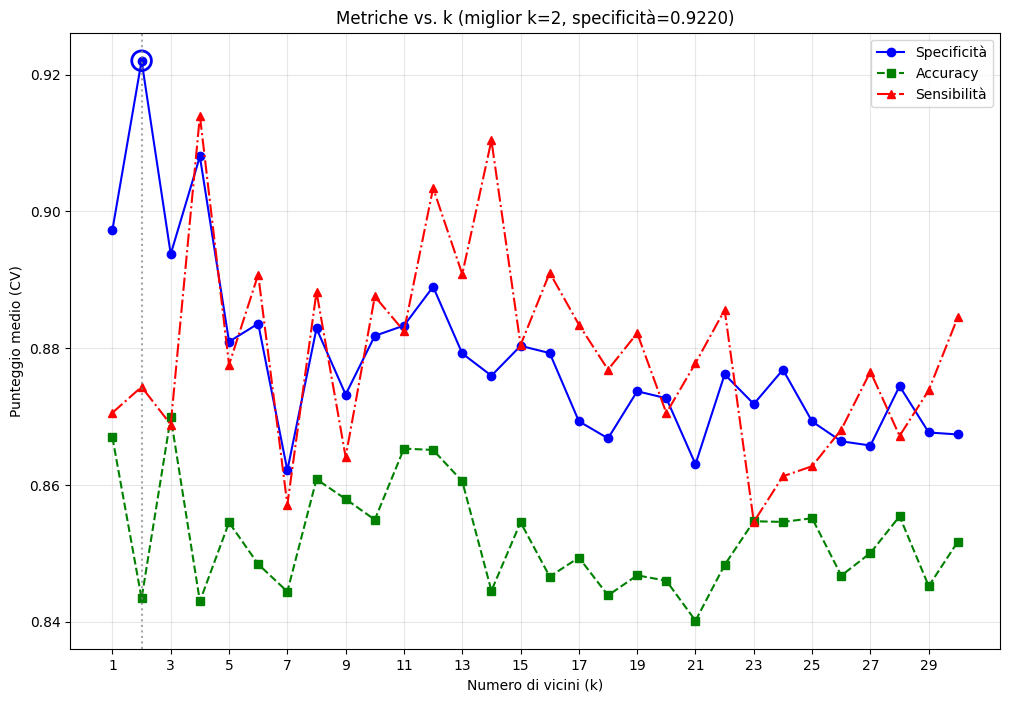

Miglior valore di k: 2, Miglior specificity: 0.9220
Con k = 2: Accuracy = 0.8434, Specificità = 0.9220, Sensibilità = 0.8743
Come suggerisce il grafico, il miglior risultato per specificity si ottiene con k = 2.

Metriche del modello ottimizzato per specificity:
Accuracy: 0.843396081159239
Specificità: 0.9220381639718024
Sensibilità: 0.8743339993339994


In [79]:
knn_opt_undersampled = KNNOptimizer()

# Run optimization
knn_opt_undersampled.optimize(
    X_train_undersampled,
    y_train_undersampled,
    k_range=range(1, 31),
    cv=cv,
    optimization_metric='specificity',
    calculate_accuracy=calculate_accuracy,
    calculate_specificity=calculate_specificity,
    calculate_sensitivity=calculate_sensitivity
)

# Plot the metrics
plt.figure()
knn_opt_undersampled.plot_metrics()
plt.show()

# Print optimization results
knn_opt_undersampled.print_results()

# Cross-validate the best model
knn_opt_undersampled.cross_validate_best_model(
    X_train_undersampled,
    y_train_undersampled,
    cv=cv,
    calculate_accuracy=calculate_accuracy,
    calculate_specificity=calculate_specificity,
    calculate_sensitivity=calculate_sensitivity
)

# Print cross-validation results
knn_opt_undersampled.print_cv_results()

# Add results to your DataFrame
results_df_training_set.loc[len(results_df_training_set)] = knn_opt_undersampled.get_results_for_dataframe(type_data='Undersampled')

# To make predictions with the best model
#knn_opt_oversampling.fit(X_train, y_train)
#y_pred = knn_opt_oversampling.predict(X_test)


# 5.2 Random Forest
For the application of the Random Forest (RF) method, it was decided to use forests consisting of 500 trees and to consider a random subset of 4 explanatory variables at each split of a tree, i.e., an approximation of the root of the total number of explanatory variables in the model. Three RF models were trained using the unbalanced training set and the two balanced training sets obtained by the oversampling and undersampling methods. Performance in terms of accuracy, class specificity of the healthy (vs. other) and sensitivity of the diseased was evaluated, obtaining good results in all cases, particularly with the RF trained on the balanced training set with undersampling, with which there is a decrease in accuracy, but an important increase in precision in classifying suspected and diseased fetuses.

In [80]:
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer
import numpy as np

# Definisci il classificatore Random Forest con 500 alberi e un massimo di 4 feature per split
rf_classifier_unbalanced = RandomForestClassifier(n_estimators=500, max_features=4, random_state=42)
rf_classifier_oversampled = RandomForestClassifier(n_estimators=500, max_features=4, random_state=42)
rf_classifier_undersampled = RandomForestClassifier(n_estimators=500, max_features=4,random_state=42)

# Definisci le metriche che vuoi calcolare
scoring = {
    'accuracy': make_scorer(calculate_accuracy),
    'specificity': make_scorer(calculate_specificity),
    'sensitivity': make_scorer(calculate_sensitivity)
}

# Valutazione delle performance attraverso cross-validation
cv_unbalanced = cross_validate(rf_classifier_unbalanced, X_train, y_train, cv=cv, scoring=scoring)
cv_oversampled = cross_validate(rf_classifier_oversampled, X_train_oversampled, y_train_oversampled, cv=cv, scoring=scoring)
cv_undersampled = cross_validate(rf_classifier_undersampled, X_train_undersampled, y_train_undersampled, cv=cv, scoring=scoring)

# Visualizza le metriche
print("Unbalanced Metrics:")
print("Accuracy:", np.mean(cv_unbalanced['test_accuracy']))
print("Specificity1:", np.mean(cv_unbalanced['test_specificity']))
print("Sensitivity3:", np.mean(cv_unbalanced['test_sensitivity']))

# Oversampled Metrics
print("\nOversampled Metrics:")
print("Accuracy:", np.mean(cv_oversampled['test_accuracy']))
print("Specificity1:", np.mean(cv_oversampled['test_specificity']))
print("Sensitivity3:", np.mean(cv_oversampled['test_sensitivity']))

# Undersampled Metrics
print("\nUndersampled Metrics:")
print("Accuracy:", np.mean(cv_undersampled['test_accuracy']))
print("Specificity1:", np.mean(cv_undersampled['test_specificity']))
print("Sensitivity3:", np.mean(cv_undersampled['test_sensitivity']))

results_df_training_set.loc[len(results_df_training_set)] = [
    "RF",
    np.mean(cv_unbalanced['test_accuracy']),
    np.mean(cv_unbalanced['test_specificity']),
    np.mean(cv_unbalanced['test_sensitivity'])
]
results_df_training_set.loc[len(results_df_training_set)] = [
    "RFO",
    np.mean(cv_oversampled['test_accuracy']),
    np.mean(cv_oversampled['test_specificity']),
    np.mean(cv_oversampled['test_sensitivity'])
]

results_df_training_set.loc[len(results_df_training_set)] = [
    "RFU",
    np.mean(cv_undersampled['test_accuracy']),
    np.mean(cv_undersampled['test_specificity']),
    np.mean(cv_undersampled['test_sensitivity'])
]

Unbalanced Metrics:
Accuracy: 0.9515903817148162
Specificity1: 0.9345252438459715
Sensitivity3: 0.9590411549235078

Oversampled Metrics:
Accuracy: 0.9909294455893953
Specificity1: 0.9865959948298093
Sensitivity3: 0.996246212546291

Undersampled Metrics:
Accuracy: 0.9272629176457878
Specificity1: 0.9359793833242108
Sensitivity3: 0.9406410256410258
Unbalanced Metrics:
Accuracy: 0.9515903817148162
Specificity1: 0.9345252438459715
Sensitivity3: 0.9590411549235078

Oversampled Metrics:
Accuracy: 0.9909294455893953
Specificity1: 0.9865959948298093
Sensitivity3: 0.996246212546291

Undersampled Metrics:
Accuracy: 0.9272629176457878
Specificity1: 0.9359793833242108
Sensitivity3: 0.9406410256410258


In [81]:
results_df_training_set

,Method,Accuracy,Specificity1,Sensitivity3
0,KNN None (ottimizzato per specificity),0.923525,0.934727,0.977381
1,KNN Oversampling (ottimizzato per specificity),0.980343,0.979153,0.996263
2,KNN Undersampled (ottimizzato per specificity),0.843396,0.922038,0.874334
3,RF,0.951590,0.934525,0.959041
4,RFO,0.990929,0.986596,0.996246
5,RFU,0.927263,0.935979,0.940641


,Method,Accuracy,Specificity1,Sensitivity3
0,KNN None (ottimizzato per specificity),0.923525,0.934727,0.977381
1,KNN Oversampling (ottimizzato per specificity),0.980343,0.979153,0.996263
2,KNN Undersampled (ottimizzato per specificity),0.843396,0.922038,0.874334
3,RF,0.951590,0.934525,0.959041
4,RFO,0.990929,0.986596,0.996246
5,RFU,0.927263,0.935979,0.940641


## 5.3 Support Vector Machine
The Support Vectorr Machine (SVM) method was applied on the normalized data without any prior balancing technique. The latter issue was handled by the introduction of class-specific C hyperparameters.
Briefly, in the Soft-margin formulation of the SVM, the hyperparameter C defines a trade-off between the penalty to be given to misclassifications and by the magnitude of the margin: as C increases, the tolerance for misclassifications decreases and consequently the margin. By introducing hyperparameters c1, c2 and c3, one is able to penalize any misclassification errors differently as the class varies. In particular, the highest cost will be attributed to the sick class since it is the least represented and at the same time, the one of greatest interest in the present analysis.
Regarding the choice of hyperparameters, several configurations of the hyperparameters were evaluated and the best one was chosen taking into account the performance obtained with a 10-fold Cross-Validation.
The possible values of C and γ were chosen exponentially.

In [82]:
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix
import pandas as pd

# Definisco le metriche da calcolare
scoring = {
    'accuracy': make_scorer(calculate_accuracy),
    'specificity': make_scorer(calculate_specificity),
    'sensitivity': make_scorer(calculate_sensitivity)
}

# Crea un DataFrame per i risultati
results_df_svm = pd.DataFrame(columns=['C1', 'C2', 'C3', 'C', 'gamma', 'Accuracy', 'Specificity1', 'Sensitivity3'])

# Itera attraverso i diversi set di iperparametri
for params in [
    (1, 10, 100,  10, 1.00),
    (1,  5, 100,  10, 1.00),
    (1,  5, 100, 100, 1.00),
    (1,  1,   1, 500, 1.00)
]:
    # Estrai i valori degli iperparametri
    C1, C2, C3, C, gamma = params

    # Crea un classificatore SVM con gli iperparametri specificati
    svm = SVC(C=C, gamma=gamma, class_weight={1.0: C1, 2.0: C2, 3.0: C3})

    # Esegui la 10-fold Cross-Validation
    cv_results = cross_validate(svm, X_train, y_train, cv=cv, scoring=scoring)

    # Calcola le metriche manualmente
    accuracy = np.mean(cv_results['test_accuracy'])
    specificity1 = np.mean(cv_results['test_specificity'])
    sensitivity3 = np.mean(cv_results['test_sensitivity'])

    # Aggiungi i risultati al DataFrame utilizzando loc
    results_df_svm.loc[len(results_df_svm)] = [C1, C2, C3, C, gamma, accuracy, specificity1, sensitivity3]

# Visualizza i risultati
print("Table 2:")
print(results_df_svm)
results_df_training_set.loc[len(results_df_training_set)] = [
    "SVM",
    results_df_svm["Accuracy"][3],
    results_df_svm["Specificity1"][3],
    results_df_svm["Sensitivity3"][3]
]

results_df_training_set.loc[len(results_df_training_set)] = [
    "SVMW",
    results_df_svm["Accuracy"][2],
    results_df_svm["Specificity1"][2],
    results_df_svm["Sensitivity3"][2]
]

Table 2:
    C1    C2     C3      C  gamma  Accuracy  Specificity1  Sensitivity3
0  1.0  10.0  100.0   10.0    1.0  0.909523      0.723142      0.860227
1  1.0   5.0  100.0   10.0    1.0  0.911961      0.732087      0.845131
2  1.0   5.0  100.0  100.0    1.0  0.930090      0.801789      0.880403
3  1.0   1.0    1.0  500.0    1.0  0.937326      0.858435      0.897308
Table 2:
    C1    C2     C3      C  gamma  Accuracy  Specificity1  Sensitivity3
0  1.0  10.0  100.0   10.0    1.0  0.909523      0.723142      0.860227
1  1.0   5.0  100.0   10.0    1.0  0.911961      0.732087      0.845131
2  1.0   5.0  100.0  100.0    1.0  0.930090      0.801789      0.880403
3  1.0   1.0    1.0  500.0    1.0  0.937326      0.858435      0.897308


In Table 2, we report the values obtained in terms of accuracy, specificity for the healthy class (vs. others) and sensitivity for the diseased class (vs. others), for what were the best configurations. It is immediate to note that as the cost attributed to class 3 increases, the percentage of correctly classified sick fetuses increases dramatically. At the same time, the classifier suffers slightly in terms of accuracy, however, it is believed that the best possible configuration is row 3. The performance of the latter will be compared with that of other classifiers.

## 5.4 Choosing the best model.
To choose the model to be used in the testing phase, the performance of the various models analyzed, obtained by 10-fold cross validation, is compared. In particular, for each of them, not only the accuracy (1 - generalization error) is considered, since in the context under analysis the correct classification of diseased fetuses is of greater importance than that of healthy fetuses. To take this into account, the specificity of the class of healthy fetuses (vs. others) and the sensitivity of the class of sick fetuses are also evaluated.

In [83]:
print("Tabella 3:")
results_df_training_set

Tabella 3:


,Method,Accuracy,Specificity1,Sensitivity3
0,KNN None (ottimizzato per specificity),0.923525,0.934727,0.977381
1,KNN Oversampling (ottimizzato per specificity),0.980343,0.979153,0.996263
2,KNN Undersampled (ottimizzato per specificity),0.843396,0.922038,0.874334
3,RF,0.951590,0.934525,0.959041
4,RFO,0.990929,0.986596,0.996246
5,RFU,0.927263,0.935979,0.940641
6,SVM,0.937326,0.858435,0.897308
7,SVMW,0.930090,0.801789,0.880403


Tabella 3:


,Method,Accuracy,Specificity1,Sensitivity3
0,KNN None (ottimizzato per specificity),0.923525,0.934727,0.977381
1,KNN Oversampling (ottimizzato per specificity),0.980343,0.979153,0.996263
2,KNN Undersampled (ottimizzato per specificity),0.843396,0.922038,0.874334
3,RF,0.951590,0.934525,0.959041
4,RFO,0.990929,0.986596,0.996246
5,RFU,0.927263,0.935979,0.940641
6,SVM,0.937326,0.858435,0.897308
7,SVMW,0.930090,0.801789,0.880403


Table 3 shows the performance of the models: it can be seen that excellent accuracy values were obtained in all cases, but the selected model is the Random Forest with oversampling balancing also presents the best classification of suspected and diseased fetuses.

However, during the testing phase it was decided to evaluate the original distribution of the classes, without performing balancing so as to test the model on data that accurately reflects the prevalence of the classes in the real population, so the Random Forest without balancing is used.

## 5.5 Testing phase.
First, the test set was normalized and variables that were found to be overly correlated with other explanatory variables in the preprocessing phase were excluded.
Next, an unbalanced training set was created and a Random Forest was estimated on this data set. Finally, with the obtained model, the observations of the test set were ranked, the results of which are shown in the confusion matrix in Figure 8.

In [84]:
columns = ['LB', 'AC', 'UC', 'DL', 'DP', 'ASTV', 'MSTV', 'ALTV', 'MLTV', 'Width',
           'Max', 'Nmax', 'Mean', 'Variance', 'Tendency']

test_cardio = pd.read_csv("test_cardio.csv")
X_test = test_cardio[columns].copy()
y_test = test_cardio['NSP'].copy()

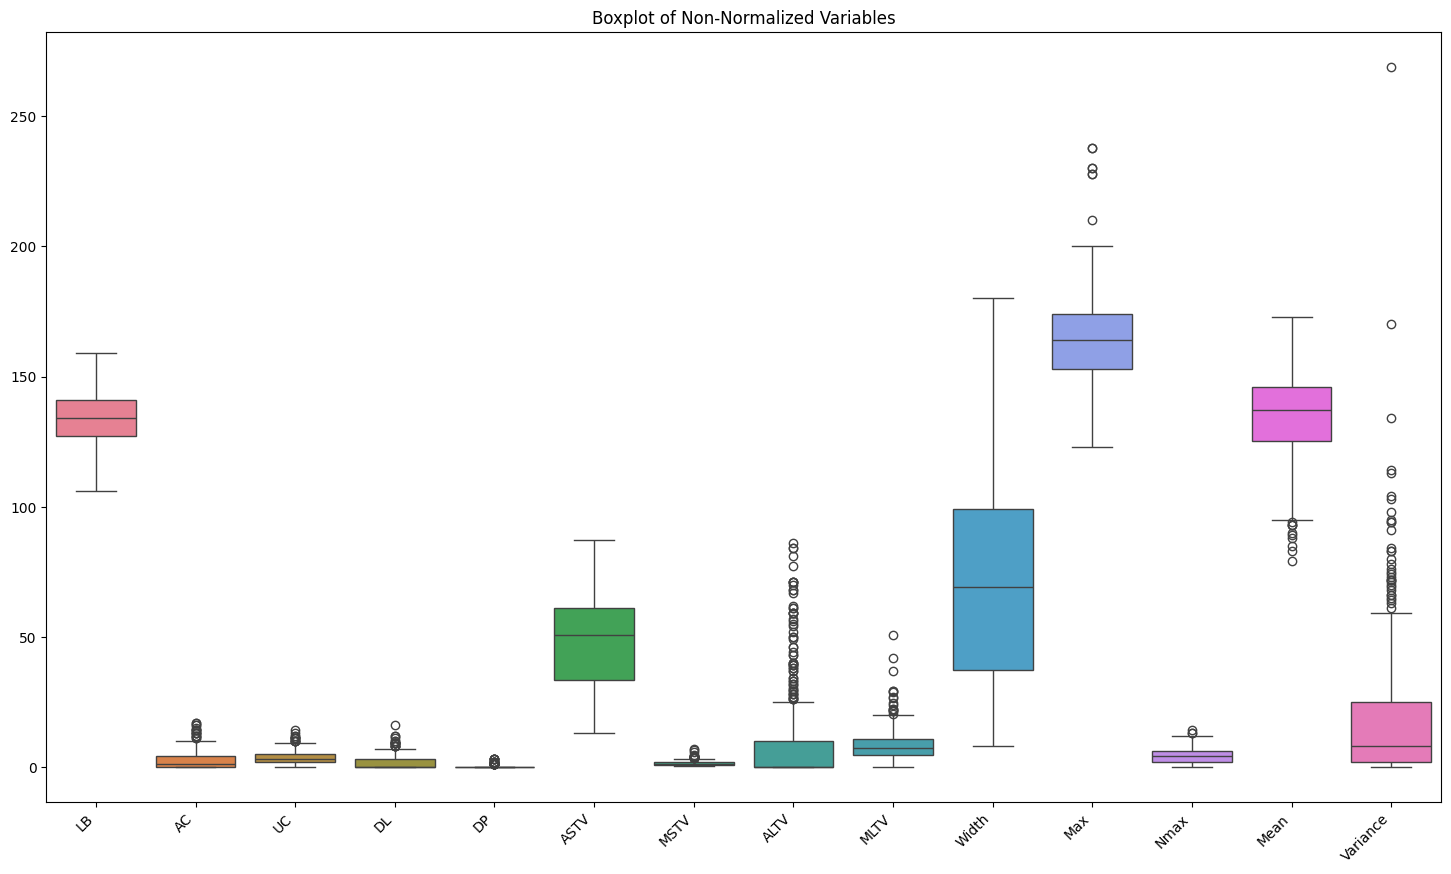

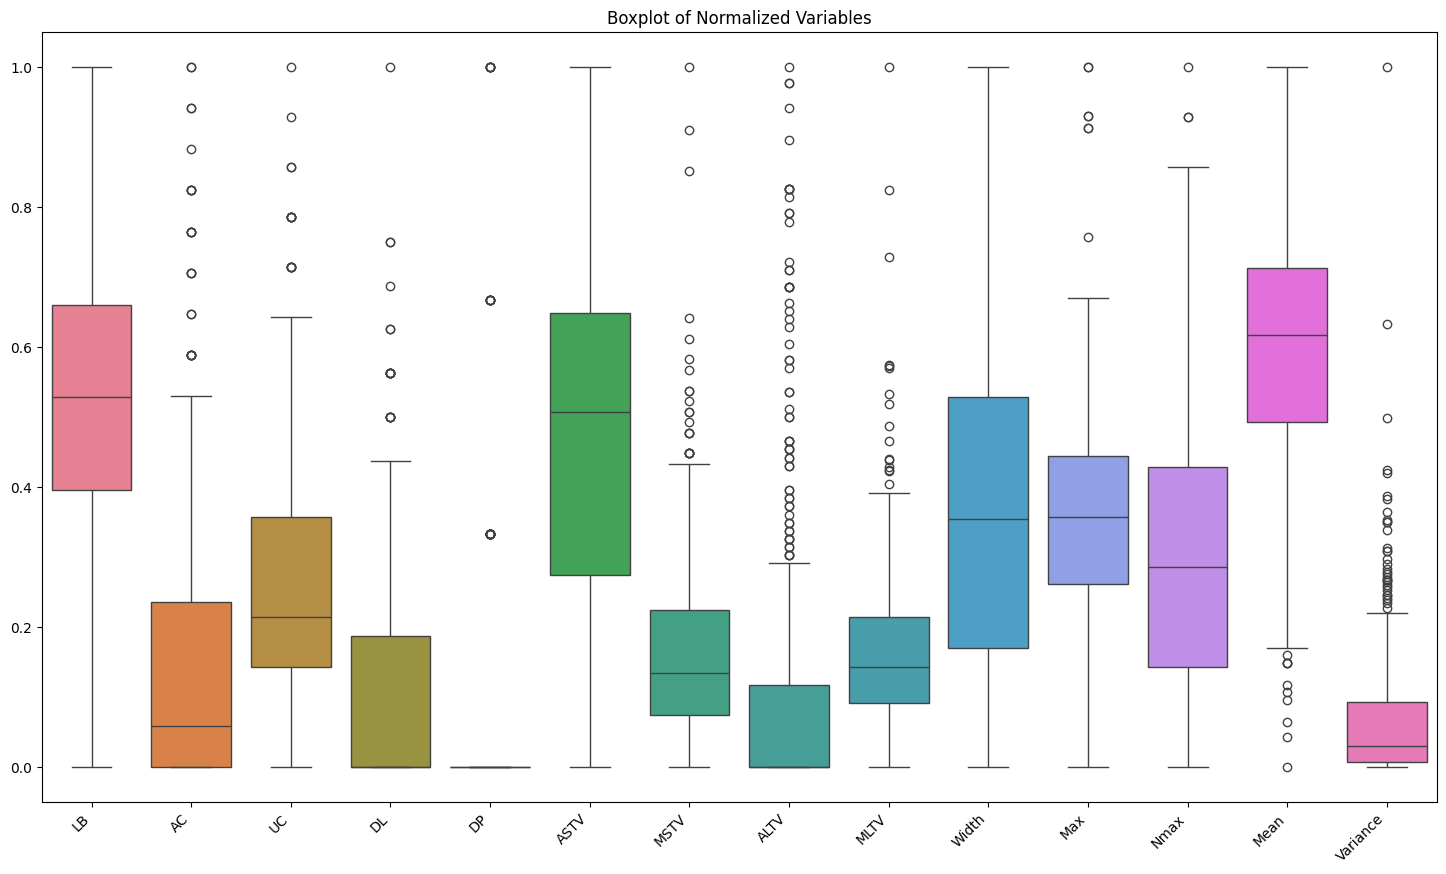

In [35]:
# Normalizzo test set
colonnes_numeriche = ['LB', 'AC', 'UC', 'DL', 'DP', 'ASTV', 'MSTV', 'ALTV', 'MLTV', 'Width',
                      'Max', 'Nmax', 'Mean', 'Variance']

# Crea un subset del DataFrame contenente solo le colonne numeriche
subset_boxplot = X_test[colonnes_numeriche]

# Visualizza i boxplot delle variabili non normalizzate affiancate
plt.figure(figsize=(18, 10))
sns.boxplot(data=subset_boxplot, orient='v')
plt.title('Boxplot of Non-Normalized Variables')
plt.xticks(rotation=45, ha='right')  # Ruota le etichette sull'asse x per una migliore leggibilità
plt.show()

# Normalizza le colonne numeriche
scaler = MinMaxScaler()
X_test[colonnes_numeriche] = scaler.fit_transform(X_test[colonnes_numeriche])

# Visualizza i boxplot delle variabili normalizzate affiancate
plt.figure(figsize=(18, 10))
sns.boxplot(data=X_test[colonnes_numeriche], orient='v')
plt.title('Boxplot of Normalized Variables')
plt.xticks(rotation=45, ha='right')  # Ruota le etichette sull'asse x per una migliore leggibilità
plt.show()

In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

# Seleziona solo le colonne presenti nel training set
X_test_norm = X_test.copy()#[X_train.columns.values]

# Definisci il classificatore Random Forest con 500 alberi e un massimo di 4 feature per split
test_rf_classifier_unbalanced = RandomForestClassifier(n_estimators=500, max_features=4, random_state=42)

# Allena il modello sugli unbalanced data
test_rf_classifier_unbalanced.fit(X_train, y_train.values.ravel())

# Calcola le previsioni sugli unbalanced data
y_pred_unbalanced = test_rf_classifier_unbalanced.predict(X_test_norm)

# Calcola la matrice di confusione per gli unbalanced data
cm_class_unbalanced = confusion_matrix(y_test, y_pred_unbalanced)
print("Matrice di Confusione Unbalanced")
print(f"{cm_class_unbalanced}")

Matrice di Confusione Unbalanced
[[323   8   1]
 [ 17  38   4]
 [  1   3  31]]


In [37]:
def calculate_metrics_by_class(confusion_matrix):
    num_classes = confusion_matrix.shape[0]
    sensitivity = np.zeros(num_classes)
    specificity = np.zeros(num_classes)
    pos_pred_value = np.zeros(num_classes)
    neg_pred_value = np.zeros(num_classes)
    prevalence = np.zeros(num_classes)
    detection_rate = np.zeros(num_classes)
    detection_prevalence = np.zeros(num_classes)

    for i in range(num_classes):
        tp = confusion_matrix[i, i]
        fp = np.sum(confusion_matrix[:, i]) - tp
        fn = np.sum(confusion_matrix[i, :]) - tp
        tn = np.sum(confusion_matrix) - tp - fp - fn

        sensitivity[i] = tp / (tp + fn) if (tp + fn) != 0 else 0
        specificity[i] = tn / (tn + fp) if (tn + fp) != 0 else 0
        pos_pred_value[i] = tp / (tp + fp) if (tp + fp) != 0 else 0
        neg_pred_value[i] = tn / (tn + fn) if (tn + fn) != 0 else 0
        prevalence[i] = (tp + fn) / np.sum(confusion_matrix) if np.sum(confusion_matrix) != 0 else 0
        detection_rate[i] = tp / (tp + fn) if (tp + fn) != 0 else 0
        detection_prevalence[i] = (tp + fp) / np.sum(confusion_matrix) if np.sum(confusion_matrix) != 0 else 0

    balanced_accuracy = (sensitivity + specificity) / 2

    return sensitivity, specificity, pos_pred_value, neg_pred_value, prevalence, detection_rate, detection_prevalence, balanced_accuracy

# Calcola e stampa le metriche per ogni classe sugli unbalanced data
sensitivity, specificity, pos_pred_value, neg_pred_value, \
    prevalence, detection_rate, detection_prevalence, balanced_accuracy = calculate_metrics_by_class(cm_class_unbalanced)

test_result = pd.DataFrame(columns=["", "Class 1:", "Class 2:", "Class 3:"])
test_result = pd.DataFrame(columns=["Class 1:", "Class 2:", "Class 3:"])
test_result.loc["Sensitivity"] = [sensitivity[0], sensitivity[1], sensitivity[2]]
test_result.loc["Specificity"] = [specificity[0], specificity[1], specificity[2]]
test_result.loc["Pos Pred Value"] = [pos_pred_value[0], pos_pred_value[1], pos_pred_value[2]]
test_result.loc["Neg Pred Value"] = [neg_pred_value[0], neg_pred_value[1], neg_pred_value[2]]
test_result.loc["Prevalence"] = [prevalence[0], prevalence[1], prevalence[2]]
test_result.loc["Detection Rate"] = [detection_rate[0], detection_rate[1], detection_rate[2]]
test_result.loc["Detection Prevalence"] = [detection_prevalence[0], detection_prevalence[1], detection_prevalence[2]]
test_result.loc["Balanced Accuracy"] = [balanced_accuracy[0], balanced_accuracy[1], balanced_accuracy[2]]

In [38]:
print("Figura 8: Statistics by Class:")
print(test_result)
print("Unbalanced Confusion Matrix")
print(f"{cm_class_unbalanced}")

Figura 8: Statistics by Class:
                      Class 1:  Class 2:  Class 3:
Sensitivity           0.972892  0.644068  0.885714
Specificity           0.808511  0.970027  0.987212
Pos Pred Value        0.947214  0.775510  0.861111
Neg Pred Value        0.894118  0.944297  0.989744
Prevalence            0.779343  0.138498  0.082160
Detection Rate        0.972892  0.644068  0.885714
Detection Prevalence  0.800469  0.115023  0.084507
Balanced Accuracy     0.890701  0.807048  0.936463
Unbalanced Confusion Matrix
[[323   8   1]
 [ 17  38   4]
 [  1   3  31]]


The classification yielded excellent results in terms of minimizing fetuses misclassified as healthy: only one diseased fetus was classified as healthy, and eight at-risk fetuses were classified as healthy.

# 6 Binary classification.
In both the training and testing phases, the "suspects" class was the most difficult to discriminate against the better results for the classifications of "healthy" and "sick" fetuses. Consistent with what was observed in the clustering phase, the classification results also raise doubts as to whether a well-defined "suspects" label discriminated from the others actually exists in the population of interest. In the following section we therefore aim to explore this assumption that the "suspects" label can be interpreted as a flaw in the uncertainty of the physicians who "supervised" the dataset. It makes sense to think that fetuses labeled as "suspicious" are actually healthy or sick therefore, we set out to estimate the best possible model to solve the binary classification problem between "healthy" and "sick" with the aim of providing a prediction about the true status of the instances originally considered "suspicious." All instances labeled as suspicious are then removed from the initial dataset, which in this section will be considered as unsupervised with respect to the now binary target variable "NSP." The expected result will be validated in terms of robustness in classifying the instances with respect to using the different classification algorithms.

In [39]:
import pandas as pd
import numpy as np

d1 = pd.read_csv("train_cardio.csv")
d2 = pd.read_csv("test_cardio.csv")
df = pd.concat([d1, d2], ignore_index=True)
binary_dataset = df.copy()

## 6.1 Choosing the best model.
After normalizing the training set devoid of the suspect fetus class and excluding unnecessary explanatory variables identified in the preprocessing phase, the same types of models analyzed in the classification with three classes were considered to evaluate performance in the binary case. The hyperparameters of the various models were optimized in the same way as seen in the three-class classification case, and 10-fold cross validation was applied to evaluate performance in terms of accuracy, specificity, and sensitivity (values shown in Table 4).

### 6.1.1 Application of pre-processing

In [40]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold, train_test_split

# Normalize the numerical columns
scaler = MinMaxScaler()
numeric_columns = ['LB', 'AC', 'UC', 'DL', 'DP', 'ASTV', 'MSTV', 'ALTV', 'MLTV', 'Width',
       'Max', 'Nmax', 'Mean', 'Variance']
binary_dataset[numeric_columns] = scaler.fit_transform(binary_dataset[numeric_columns])

# Select columns only necessary
binary_dataset = binary_dataset[['LB', 'AC', 'UC', 'DL', 'DP', 'ASTV', 'MSTV', 'ALTV', 'MLTV', 'Width',
       'Max', 'Nmax', 'Mean', 'Variance', 'Tendency', 'NSP']].copy()

In [41]:
dataset_before_binarization = binary_dataset.copy()
binary_dataset = binary_dataset.drop(binary_dataset[binary_dataset['NSP'] == 2.0].index)
print(f"Classi presenti ora nel dataset: {np.unique(binary_dataset['NSP'])}")

Classi presenti ora nel dataset: [1. 3.]


In [42]:
# I divide the dataset into training set (80%) and test set (20%), maintaining the proportion of NSP labels
labels = binary_dataset['NSP']
train_set_binary, test_set_binary = train_test_split(binary_dataset, test_size=0.2, stratify=labels, random_state=42)

# DataFrame per i risultati sul training set
results_df_training_set_BINARY = pd.DataFrame(columns=["Method", "Accuracy", "Specificity1", "Sensitivity3"])
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [43]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

# Define X_train e y_train
columns = ['LB', 'AC', 'UC', 'DL', 'DP', 'ASTV', 'MSTV', 'ALTV', 'MLTV', 'Width',
       'Max', 'Nmax', 'Mean', 'Variance', 'Tendency']
X_train = train_set_binary[columns]
y_train = train_set_binary['NSP']

# Define  oversampler e undersampler
oversampler = RandomOverSampler(random_state=42)
undersampler = RandomUnderSampler(random_state=42)

# Apply oversampling
X_train_oversampled, y_train_oversampled = oversampler.fit_resample(X_train, y_train)

# Apply undersampling
X_train_undersampled, y_train_undersampled = undersampler.fit_resample(X_train, y_train)

/Users/lorenzodefeo/Desktop/Python/Evaluating-Fetal-Well-being-Machine-Learning-Models-for-Cardiotocography-Analysis-and-Prediction/venv/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/lorenzodefeo/Desktop/Python/Evaluating-Fetal-Well-being-Machine-Learning-Models-for-Cardiotocography-Analysis-and-Prediction/venv/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/Users/lorenzodefeo/Desktop/Python/Evaluating-Fetal-Well-being-Machine-Learning-Models-for-Cardiotocography-Analysis-and-Prediction/venv/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed 

### 6.1.2 KNN

In [44]:
from sklearn.model_selection import cross_val_predict
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix

def plot_cross_validation_results(k_values, accuracy_scores, best_k, best_accuracy):
    """
    Plot the results of cross-validation for different values of k.

    Parameters:
    - k_values (array): Array of k values.
    - accuracy_scores (array): Array of accuracy scores for corresponding k values.
    - best_k (int): Best k value selected during cross-validation.
    - best_accuracy (float): Accuracy corresponding to the best k value.
    """

    plt.figure(figsize=(10, 6))
    plt.plot(k_values, accuracy_scores, marker='o', linestyle='-', color='b')
    plt.title('Hyperparameter k evaluation by Cross Validation')
    plt.xlabel('Number of neighbors (k)')
    plt.ylabel('Accuracy')
    plt.xticks(k_values)
    plt.axvline(x=best_k, color='r', linestyle='--', label=f'Best k: {best_k}\nAccuracy: {best_accuracy:.4f}')
    plt.legend()
    plt.show()


def find_accuracy_scores(k_values, X_train, y_train):
    # Inizializza la lista per salvare gli score di accuracy
    accuracy_scores = []
    for k in k_values:
        knn_model = KNeighborsClassifier(n_neighbors=k)
        y_train_pred = cross_val_predict(knn_model, X_train, y_train, cv=10)

        # Calcola l'accuracy
        acc_score = accuracy_score(y_train, y_train_pred)

        # Salva l'accuracy
        accuracy_scores.append(acc_score)
    return accuracy_scores

def calculate_accuracy(y_true, y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred)
    true_positive = conf_matrix[1, 1]
    true_negative = conf_matrix[0, 0]
    false_positive = conf_matrix[0, 1]
    false_negative = conf_matrix[1, 0]

    accuracy = (true_positive + true_negative) / (true_positive + true_negative + false_positive + false_negative)

    return accuracy

def calculate_specificity(y_true, y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred)
    true_negative = conf_matrix[0, 0]
    false_positive = conf_matrix[0, 1]

    specificity = true_negative / (true_negative + false_positive)

    return specificity

def calculate_sensitivity(y_true, y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred)
    true_positive = conf_matrix[1, 1]
    false_negative = conf_matrix[1, 0]

    sensitivity = true_positive / (true_positive + false_negative)

    return sensitivity



#### KNN: Case with unbalanced data.

<Figure size 640x480 with 0 Axes>

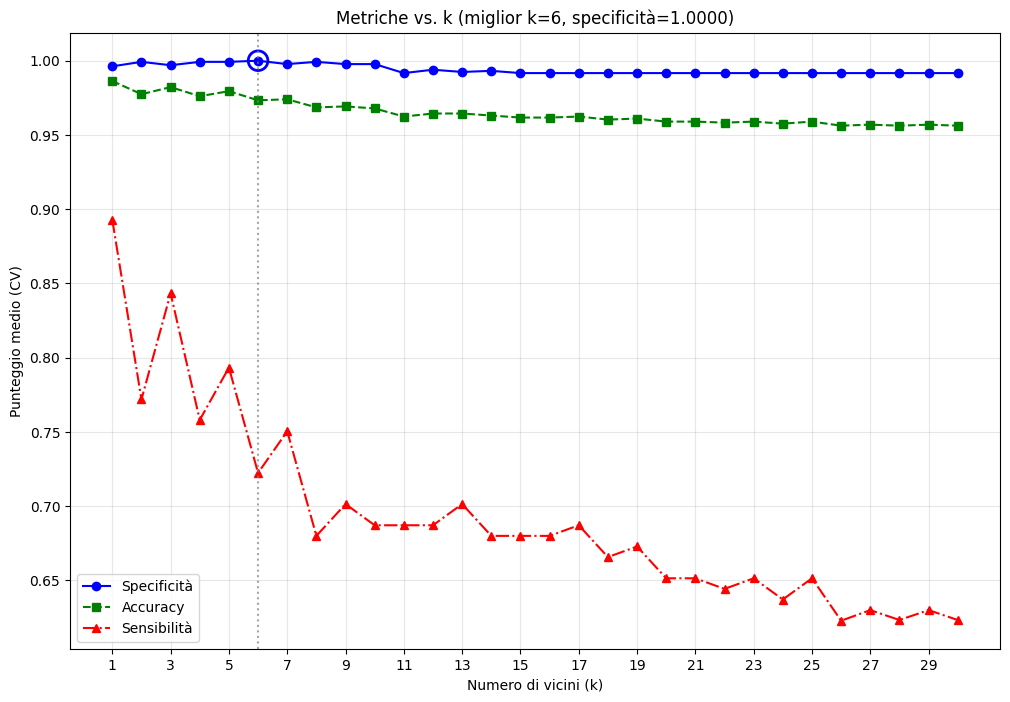

Miglior valore di k: 6, Miglior specificity: 1.0000
Con k = 6: Accuracy = 0.9733, Specificità = 1.0000, Sensibilità = 0.7224
Come suggerisce il grafico, il miglior risultato per specificity si ottiene con k = 6.

Metriche del modello ottimizzato per specificity:
Accuracy: 0.9733435840089459
Specificità: 1.0
Sensibilità: 0.7223809523809523


In [45]:
# Uso della classe KNNOptimizer, con dataset NON SBILANCIATO
knn_opt_binary_class = KNNOptimizer()

# Run optimization
knn_opt_binary_class.optimize(
    X_train,
    y_train,
    k_range=range(1, 31),
    cv=cv,
    optimization_metric='specificity',
    calculate_accuracy=calculate_accuracy,
    calculate_specificity=calculate_specificity,
    calculate_sensitivity=calculate_sensitivity
)

# Plot the metrics
plt.figure()
knn_opt_binary_class.plot_metrics()
plt.show()

# Print optimization results
knn_opt_binary_class.print_results()

# Cross-validate the best model
knn_opt_binary_class.cross_validate_best_model(
    X_train,
    y_train,
    cv=cv,
    calculate_accuracy=calculate_accuracy,
    calculate_specificity=calculate_specificity,
    calculate_sensitivity=calculate_sensitivity
)

# Print cross-validation results
knn_opt_binary_class.print_cv_results()

# Add results to your DataFrame
results_df_training_set.loc[len(results_df_training_set)] = knn_opt_binary_class.get_results_for_dataframe(model_name="KNN")

# To make predictions with the best model
#knn_opt_binary_class.fit(X_train, y_train)
#y_pred = knn_opt_binary_class.predict(X_test)

#### KNN Oversampling

<Figure size 640x480 with 0 Axes>

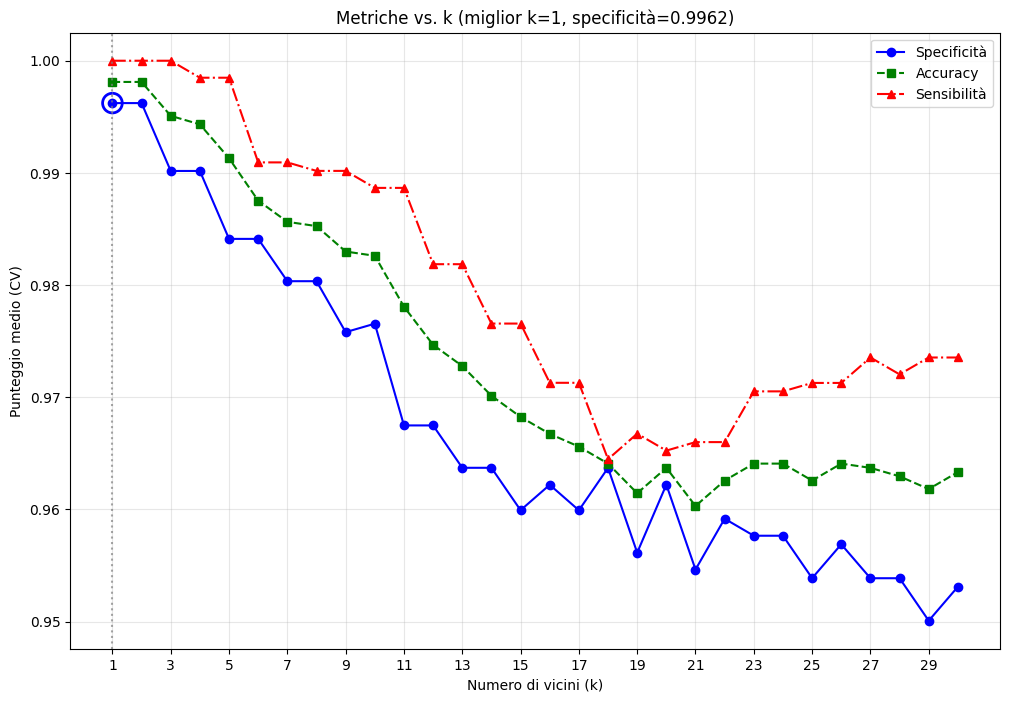

Miglior valore di k: 1, Miglior specificity: 0.9962
Con k = 1: Accuracy = 0.9981, Specificità = 0.9962, Sensibilità = 1.0000
Come suggerisce il grafico, il miglior risultato per specificity si ottiene con k = 1.

Metriche del modello ottimizzato per specificity:
Accuracy: 0.9981089193825042
Specificità: 0.9962235133287765
Sensibilità: 1.0


In [46]:
# Uso della classe KNNOptimizer, con dataset NON SBILANCIATO
knn_opt_oversampled_binary_class = KNNOptimizer()

# Run optimization
knn_opt_oversampled_binary_class.optimize(
    X_train_oversampled,
    y_train_oversampled,
    k_range=range(1, 31),
    cv=cv,
    optimization_metric='specificity',
    calculate_accuracy=calculate_accuracy,
    calculate_specificity=calculate_specificity,
    calculate_sensitivity=calculate_sensitivity
)

# Plot the metrics
plt.figure()
knn_opt_oversampled_binary_class.plot_metrics()
plt.show()

# Print optimization results
knn_opt_oversampled_binary_class.print_results()

# Cross-validate the best model
knn_opt_oversampled_binary_class.cross_validate_best_model(
    X_train_oversampled,
    y_train_oversampled,
    cv=cv,
    calculate_accuracy=calculate_accuracy,
    calculate_specificity=calculate_specificity,
    calculate_sensitivity=calculate_sensitivity
)

# Print cross-validation results
knn_opt_oversampled_binary_class.print_cv_results()

# Add results to your DataFrame
results_df_training_set_BINARY.loc[len(results_df_training_set)] = knn_opt_oversampled_binary_class.get_results_for_dataframe(model_name='KNNO')

# To make predictions with the best model
#knn_opt_oversampled.fit(X_train, y_train)
#y_pred = knn_opt_oversampled.predict(X_test)

#### KNN Undersampling

<Figure size 640x480 with 0 Axes>

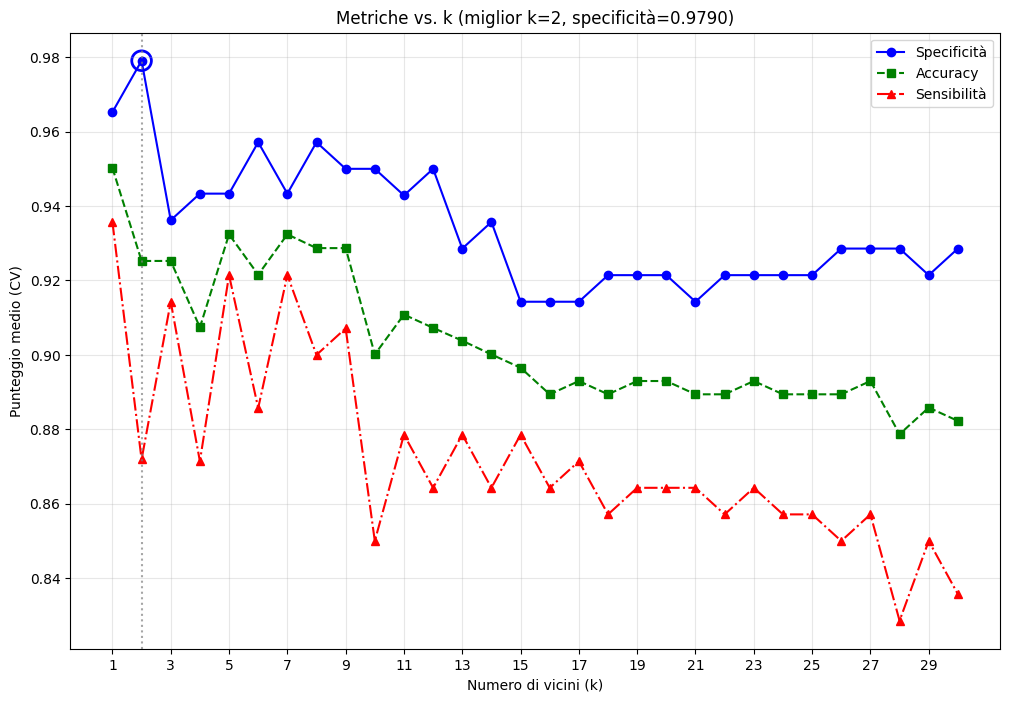

Miglior valore di k: 2, Miglior specificity: 0.9790
Con k = 2: Accuracy = 0.9252, Specificità = 0.9790, Sensibilità = 0.8719
Come suggerisce il grafico, il miglior risultato per specificity si ottiene con k = 2.

Metriche del modello ottimizzato per specificity:
Accuracy: 0.9252463054187192
Specificità: 0.9790476190476192
Sensibilità: 0.8719047619047618


In [47]:
# Uso della classe KNNOptimizer, con dataset SBILANCIATO UNDERSAMPLING
knn_opt_undersampled_binary_class = KNNOptimizer()

# Run optimization
knn_opt_undersampled_binary_class.optimize(
    X_train_undersampled,
    y_train_undersampled,
    k_range=range(1, 31),
    cv=cv,
    optimization_metric='specificity',
    calculate_accuracy=calculate_accuracy,
    calculate_specificity=calculate_specificity,
    calculate_sensitivity=calculate_sensitivity
)

# Plot the metrics
plt.figure()
knn_opt_undersampled_binary_class.plot_metrics()
plt.show()

# Print optimization results
knn_opt_undersampled_binary_class.print_results()

# Cross-validate the best model
knn_opt_undersampled_binary_class.cross_validate_best_model(
    X_train_undersampled,
    y_train_undersampled,
    cv=cv,
    calculate_accuracy=calculate_accuracy,
    calculate_specificity=calculate_specificity,
    calculate_sensitivity=calculate_sensitivity
)

# Print cross-validation results
knn_opt_undersampled_binary_class.print_cv_results()

# Add results to your DataFrame
results_df_training_set_BINARY.loc[len(results_df_training_set)] = knn_opt_undersampled_binary_class.get_results_for_dataframe(model_name='KNNU')

# To make predictions with the best model
#knn_opt_undersampled_binary_class.fit(X_train, y_train)
#y_pred = knn_opt_undersampled_binary_class.predict(X_test)

### 6.1.2 Random Forest

In [48]:
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix
import numpy as np

# Definisci il classificatore Random Forest con 500 alberi e un massimo di 4 feature per split
rf_classifier_unbalanced = RandomForestClassifier(n_estimators=500, max_features=4, random_state=42)
rf_classifier_oversampled = RandomForestClassifier(n_estimators=500, max_features=4, random_state=42)
rf_classifier_undersampled = RandomForestClassifier(n_estimators=500, max_features=4, random_state=42)

# Definisci le metriche che vuoi calcolare
scoring = {
    'accuracy': make_scorer(calculate_accuracy),
    'specificity': make_scorer(calculate_specificity),
    'sensitivity': make_scorer(calculate_sensitivity)
}

# Valutazione delle performance attraverso cross-validation
cv_unbalanced = cross_validate(rf_classifier_unbalanced, X_train, y_train, cv=cv, scoring=scoring)
cv_oversampled = cross_validate(rf_classifier_oversampled, X_train_oversampled, y_train_oversampled, cv=cv,
                                scoring=scoring)
cv_undersampled = cross_validate(rf_classifier_undersampled, X_train_undersampled, y_train_undersampled, cv=cv,
                                 scoring=scoring)

# Visualizza le metriche
print("Unbalanced Metrics:")
print("Accuracy:", np.mean(cv_unbalanced['test_accuracy']))
print("Specificity1:", np.mean(cv_unbalanced['test_specificity']))
print("Sensitivity3:", np.mean(cv_unbalanced['test_sensitivity']))

# Oversampled Metrics
print("\nOversampled Metrics:")
print("Accuracy:", np.mean(cv_oversampled['test_accuracy']))
print("Specificity1:", np.mean(cv_oversampled['test_specificity']))
print("Sensitivity3:", np.mean(cv_oversampled['test_sensitivity']))

# Undersampled Metrics
print("\nUndersampled Metrics:")
print("Accuracy:", np.mean(cv_undersampled['test_accuracy']))
print("Specificity1:", np.mean(cv_undersampled['test_specificity']))
print("Sensitivity3:", np.mean(cv_undersampled['test_sensitivity']))

results_df_training_set_BINARY.loc[len(results_df_training_set_BINARY)] = [
    "RF",
    np.mean(cv_unbalanced['test_accuracy']),
    np.mean(cv_unbalanced['test_specificity']),
    np.mean(cv_unbalanced['test_sensitivity'])
]
results_df_training_set_BINARY.loc[len(results_df_training_set_BINARY)] = [
    "RFO",
    np.mean(cv_oversampled['test_accuracy']),
    np.mean(cv_oversampled['test_specificity']),
    np.mean(cv_oversampled['test_sensitivity'])
]

results_df_training_set_BINARY.loc[len(results_df_training_set_BINARY)] = [
    "RFU",
    np.mean(cv_undersampled['test_accuracy']),
    np.mean(cv_undersampled['test_specificity']),
    np.mean(cv_undersampled['test_sensitivity'])
]

Unbalanced Metrics:
Accuracy: 0.9924937098126921
Specificity1: 0.9984848484848484
Sensitivity3: 0.9361904761904762

Oversampled Metrics:
Accuracy: 0.9977344196683819
Specificity1: 0.995460241512873
Sensitivity3: 1.0

Undersampled Metrics:
Accuracy: 0.9608374384236452
Specificity1: 0.9504761904761905
Sensitivity3: 0.9714285714285715


### 6.1.3 Support Vector Machine

In [49]:
from sklearn.model_selection import cross_val_predict
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, accuracy_score
import pandas as pd

# Definisco le metriche da calcolare
scoring = {
    'accuracy': make_scorer(calculate_accuracy),
    'specificity': make_scorer(calculate_specificity),
    'sensitivity': make_scorer(calculate_sensitivity)
}

# Crea un DataFrame per i risultati
results_df_svm = pd.DataFrame(columns=['C1', 'C2', 'C3', 'C', 'gamma', 'Accuracy', 'Specificity1', 'Sensitivity3'])

# Itera attraverso i diversi set di iperparametri
for params in [
    (1, 10, 100, 10, 1.00),
    (1, 5, 100, 10, 1.00),
    (1, 5, 100, 100, 1.00),
    (1, 1, 1, 500, 1.00)
]:
    # Estrai i valori degli iperparametri
    C1, C2, C3, C, gamma = params

    # Crea un classificatore SVM con gli iperparametri specificati
    svm = SVC(C=C, gamma=gamma, class_weight={1.0: C1, 2.0: C2, 3.0: C3})

    # Esegui la 10-fold Cross-Validation
    cv_results = cross_validate(svm, X_train, y_train, cv=cv, scoring=scoring)

    # Calcola le metriche manualmente
    accuracy = np.mean(cv_results['test_accuracy'])
    specificity1 = np.mean(cv_results['test_specificity'])
    sensitivity3 = np.mean(cv_results['test_sensitivity'])

    # Aggiungi i risultati al DataFrame utilizzando loc
    results_df_svm.loc[len(results_df_svm)] = [C1, C2, C3, C, gamma, accuracy, specificity1, sensitivity3]

# Visualizza i risultati
print("Table 2:")
print(results_df_svm)
results_df_training_set_BINARY.loc[len(results_df_training_set_BINARY)] = [
    "SVM",
    results_df_svm["Accuracy"][3],
    results_df_svm["Specificity1"][3],
    results_df_svm["Sensitivity3"][3]
]

results_df_training_set_BINARY.loc[len(results_df_training_set_BINARY)] = [
    "SVMW",
    results_df_svm["Accuracy"][2],
    results_df_svm["Specificity1"][2],
    results_df_svm["Sensitivity3"][2]
]

Table 2:
    C1    C2     C3      C  gamma  Accuracy  Specificity1  Sensitivity3
0  1.0  10.0  100.0   10.0    1.0  0.985663      0.992447      0.921429
1  1.0   5.0  100.0   10.0    1.0  0.985663      0.992447      0.921429
2  1.0   5.0  100.0  100.0    1.0  0.985658      0.993962      0.907143
3  1.0   1.0    1.0  500.0    1.0  0.985658      0.993962      0.907143


In [50]:
print("Table 4:")
results_df_training_set_BINARY

Table 4:


,Method,Accuracy,Specificity1,Sensitivity3
9,KNNU,0.925246,0.979048,0.871905
1,RF,0.992494,0.998485,0.936190
2,RFO,0.997734,0.995460,1.000000
3,RFU,0.960837,0.950476,0.971429
4,SVM,0.985658,0.993962,0.907143
5,SVMW,0.985658,0.993962,0.907143


Again, for the choice of the model to be used in the testing phase, we focus on optimizing the trade-off between accuracy and specificity, giving more importance to the second metric in order to optimize the correct classification of diseased fetuses. For this reason, the model considered best was still Random Forest.

## 6.3 Testing step
The test set without the class of suspected fetuses was normalized and variables that were found to be unnecessary in the preprocessing stage were excluded. Next, using the Random Forest model, the observations of the test set were classified, the results of which are shown in the confusion matrix in Figure 11.

In [51]:
columns = ['LB', 'AC', 'UC', 'DL', 'DP', 'ASTV', 'MSTV', 'ALTV', 'MLTV', 'Width',
           'Max', 'Nmax', 'Mean', 'Variance', 'Tendency']

X_test = test_set_binary[columns].copy()
y_test = test_set_binary['NSP'].copy()

In [52]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

# Seleziona solo le colonne presenti nel training set
X_test_norm = X_test.copy()  #[X_train.columns.values]

# Definisci il classificatore Random Forest con 500 alberi e un massimo di 4 feature per split
test_rf_classifier_unbalanced = RandomForestClassifier(n_estimators=500, max_features=4, random_state=42)

# Allena il modello sugli unbalanced data
test_rf_classifier_unbalanced.fit(X_train, y_train.values.ravel())

# Calcola le previsioni sugli unbalanced data
y_pred_unbalanced = test_rf_classifier_unbalanced.predict(X_test_norm)

# Calcola la matrice di confusione per i dati non bilanciati
cm_unbalanced = confusion_matrix(y_test, y_pred_unbalanced)
print("Matrice di Confusione Unbalanced:")
print(cm_unbalanced)

def calculate_metrics_binary(confusion_matrix):
    tp, fp, fn, tn = confusion_matrix.ravel()

    sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
    pos_pred_value = tp / (tp + fp) if (tp + fp) != 0 else 0
    neg_pred_value = tn / (tn + fn) if (tn + fn) != 0 else 0
    prevalence = (tp + fn) / np.sum(confusion_matrix) if np.sum(confusion_matrix) != 0 else 0
    detection_rate = tp / (tp + fn) if (tp + fn) != 0 else 0
    detection_prevalence = (tp + fp) / np.sum(confusion_matrix) if np.sum(confusion_matrix) != 0 else 0

    balanced_accuracy = (sensitivity + specificity) / 2

    return sensitivity, specificity, pos_pred_value, neg_pred_value, prevalence, detection_rate, detection_prevalence, balanced_accuracy

# Calcola e stampa le metriche per il caso binario
sensitivity, specificity, pos_pred_value, neg_pred_value, \
    prevalence, detection_rate, detection_prevalence, balanced_accuracy = calculate_metrics_binary(cm_unbalanced)

test_result = pd.DataFrame(columns=["Metriche"])
test_result.loc["Sensitivity"] = [sensitivity]
test_result.loc["Specificity"] = [specificity]
test_result.loc["Pos Pred Value"] = [pos_pred_value]
test_result.loc["Neg Pred Value"] = [neg_pred_value]
test_result.loc["Prevalence"] = [prevalence]
test_result.loc["Detection Rate"] = [detection_rate]
test_result.loc["Detection Prevalence"] = [detection_prevalence]
test_result.loc["Balanced Accuracy"] = [balanced_accuracy]

print("Statistics for the binary case:")
print(test_result)
print("Confusion Matrix Unbalanced:")
print(cm_unbalanced)

Matrice di Confusione Unbalanced:
[[330   2]
 [  3  32]]
Statistics for the binary case:
                      Metriche
Sensitivity           0.990991
Specificity           0.941176
Pos Pred Value        0.993976
Neg Pred Value        0.914286
Prevalence            0.907357
Detection Rate        0.990991
Detection Prevalence  0.904632
Balanced Accuracy     0.966084
Confusion Matrix Unbalanced:
[[330   2]
 [  3  32]]


The classification yielded excellent results in terms of minimizing fetuses misclassified as healthy, in fact quesi all diseased fetuses were classified correctly, providing a specificity of 94.11%. An excellent value of 96.61% was also obtained in terms of accuracy.

## 6.4 Classification of "suspected" fetuses.
The final goal was to propose a classification for fetuses that were in the class of at-risk fetuses in the initial dataset. Since no real label was available to validate the results, an ensemble of all the methods presented so far was opted for in order to have a measure of reliability of the classifications obtained. Therefore, the final classification for each fetus considered at risk is obtained by calculating the relative frequency of these predictions.

In [53]:
# Creo dataset con tutti i valori sospetti
dataset = dataset_before_binarization.copy()
dataset = dataset.drop(dataset[dataset['NSP'] == 1.0].index)
dataset = dataset.drop(dataset[dataset['NSP'] == 3.0].index)
X_uncertain = dataset[['LB', 'AC', 'UC', 'DL', 'DP', 'ASTV', 'MSTV', 'ALTV', 'MLTV', 'Width',
       'Max', 'Nmax', 'Mean', 'Variance', 'Tendency']].copy()
print(f"Classes now present in the dataset: {np.unique(dataset['NSP'])}")

Classes now present in the dataset: [2.]


Valuto le prestazioni del modello migliori ottenuto durante il processo di classificazione binaria, sui casi sospetti. Dato che non si ha a disposizione un'etichetta che consenta di validare i risultati, si è optato per un ansamble di tutti i metodi presentati finora in modo tale da disporre di una misura di affidabilità delle classificazioni.

In [54]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from scipy import stats

# I modelli già addestrati
rf_model = RandomForestClassifier(n_estimators=500, max_depth=4, random_state=42)
knn_model = KNeighborsClassifier(n_neighbors=knn_opt_binary_class.best_k)  # KNN standard
knn_undersampled_model = KNeighborsClassifier(n_neighbors=knn_opt_undersampled_binary_class.best_k)  # KNN con undersampling
knn_oversampled_model = KNeighborsClassifier(n_neighbors=knn_opt_oversampled_binary_class.best_k)  # KNN con oversampling
#knn_oversampled_model = KNeighborsClassifier(n_neighbors=3)  # KNN con oversampling

# Parametri del modello SVM
C1, C2, C3, C, gamma = params
svm_model = SVC(C=C, gamma=gamma, class_weight={1.0: C1, 2.0: C2, 3.0: C3})

# Addestramento dei modelli
rf_model.fit(X_train, y_train)
knn_model.fit(X_train, y_train)
knn_undersampled_model.fit(X_train_undersampled, y_train_undersampled)
knn_oversampled_model.fit(X_train_oversampled, y_train_oversampled)
svm_model.fit(X_train, y_train)

# Definiti X_uncertain per i casi incerti
# Predizioni dei modelli sui casi incerti
predictions_rf = rf_model.predict(X_uncertain)
predictions_knn = knn_model.predict(X_uncertain)
predictions_knn_under = knn_undersampled_model.predict(X_uncertain)
predictions_knn_over = knn_oversampled_model.predict(X_uncertain)
predictions_svm = svm_model.predict(X_uncertain)

# Raccolta di tutte le previsioni in un array
all_predictions = np.vstack([
    predictions_rf,
    predictions_knn,
    predictions_knn_under,
    predictions_knn_over,
    predictions_svm
])
models = ['Random Forest', 'KNN', 'KNN Oversampled', 'SVM']
models = ['Random Forest', 'KNN', 'KNN Undersampled', 'KNN Oversampled', 'SVM']

# Calcolo della moda (classe più frequente) per ogni caso incerto
final_predictions = []
reliability_scores = []

# Per ogni caso incerto (colonna nella matrice delle predizioni)
for i in range(all_predictions.shape[1]):
    # Estrai le predizioni di tutti i modelli per questo caso
    case_predictions = all_predictions[:, i]

    # Calcola la moda manualmente
    values, counts = np.unique(case_predictions, return_counts=True)
    mode_idx = np.argmax(counts)
    mode_value = values[mode_idx]

    # Salva la predizione finale (moda)
    final_predictions.append(mode_value)

    # Calcola l'affidabilità come frequenza relativa della moda
    reliability = counts[mode_idx] / len(models)
    reliability_scores.append(reliability)

# Converti le liste in array numpy
final_predictions = np.array(final_predictions)
reliability_scores = np.array(reliability_scores)

# Creazione di un DataFrame con le predizioni RF e di ensemble, più l'affidabilità
results_df = pd.DataFrame({
    'RF_Prediction': predictions_rf,
    'Ensemble_Prediction': final_predictions,
    'Reliability': reliability_scores,
    'RF_Agrees_With_Ensemble': predictions_rf == final_predictions
})

#print("Random Forest vs Ensemble predictions:")
#print(results_df)

# Calcolo della percentuale di accordo tra RF e gli altri classificatori
rf_agreement = {}
for i, model_name in enumerate(models):
    if model_name != 'Random Forest':
        same_predictions = np.sum(predictions_rf == all_predictions[i])
        percentage = (same_predictions / len(predictions_rf)) * 100
        rf_agreement[model_name] = percentage

print("\nPercentuale di accordo tra Random Forest e altri classificatori:")
for model, agreement in rf_agreement.items():
    print(f"RF vs {model}: {agreement:.2f}%")

# Creazione della tabella di confronto tra coppie di classificatori
comparison_matrix = np.zeros((len(models), len(models)))

# Calcolo delle percentuali di classificazioni identiche per ogni coppia di classificatori
for i in range(len(models)):
    for j in range(len(models)):
        if i == j:
            comparison_matrix[i, j] = 100.0  # Stesso classificatore, 100% di accordo
        else:
            # Calcola la percentuale di casi in cui i due classificatori danno lo stesso risultato
            same_predictions = np.sum(all_predictions[i] == all_predictions[j])
            percentage = (same_predictions / len(all_predictions[i])) * 100
            comparison_matrix[i, j] = percentage

# Creazione della tabella di confronto
comparison_df = pd.DataFrame(comparison_matrix, index=models, columns=models)

print("\nTabella 5: Percentuale di classificazioni identiche per ogni coppia di classificatori")
print(comparison_df)

# Analisi delle performance di Random Forest rispetto all'ensemble
rf_ensemble_agreement = np.sum(predictions_rf == final_predictions)
rf_ensemble_agreement_pct = (rf_ensemble_agreement / len(predictions_rf)) * 100

# Individuazione dei casi in cui RF è l'unico a discostarsi dall'opinione maggioritaria
rf_alone_count = 0
for i in range(len(predictions_rf)):
    other_models_agree = np.unique([
        predictions_knn[i],
        predictions_knn_under[i],
        predictions_knn_over[i],
        predictions_svm[i]
    ], return_counts=True)

    if len(other_models_agree[0]) == 1 and predictions_rf[i] != other_models_agree[0][0]:
        rf_alone_count += 1

rf_performance = {
    'Casi in cui RF concorda con ensemble': rf_ensemble_agreement,
    'Percentuale di accordo con ensemble': rf_ensemble_agreement_pct,
    'Casi in cui RF è l\'unico a discostarsi da tutti gli altri': rf_alone_count
}

print("\nAnalisi delle performance di Random Forest sui casi sospetti:")
for metric, value in rf_performance.items():
    if 'Percentuale' in metric:
        print(f"{metric}: {value:.2f}%")
    else:
        print(f"{metric}: {value}")




Percentuale di accordo tra Random Forest e altri classificatori:
RF vs KNN: 91.19%
RF vs KNN Undersampled: 76.61%
RF vs KNN Oversampled: 80.68%
RF vs SVM: 87.12%

Tabella 5: Percentuale di classificazioni identiche per ogni coppia di classificatori
                  Random Forest         KNN  KNN Undersampled  \
Random Forest        100.000000   91.186441         76.610169   
KNN                   91.186441  100.000000         82.033898   
KNN Undersampled      76.610169   82.033898        100.000000   
KNN Oversampled       80.677966   85.423729         85.762712   
SVM                   87.118644   91.186441         84.745763   

                  KNN Oversampled         SVM  
Random Forest           80.677966   87.118644  
KNN                     85.423729   91.186441  
KNN Undersampled        85.762712   84.745763  
KNN Oversampled        100.000000   88.135593  
SVM                     88.135593  100.000000  

Analisi delle performance di Random Forest sui casi sospetti:
Casi in 

In [55]:
np.mean([80.677966, 77.288136, 94.576271, 87.118644, 88.135593, 86.101695])

np.float64(85.6497175)

In [56]:
# Visualizzazione dettagliata dei casi in cui RF non concorda con l'ensemble
disagreement_cases = [i for i in range(len(predictions_rf)) if predictions_rf[i] != final_predictions[i]]
if disagreement_cases:
    print("\nDettaglio dei casi in cui Random Forest non concorda con l'ensemble:")
    for i in disagreement_cases:
        print(f"Caso {i+1}: RF={predictions_rf[i]}, KNN={predictions_knn[i]}, " +
               f"KNN_Under={predictions_knn_under[i]}" +
              f", KNN_Over={predictions_knn_over[i]}, " +
              f"SVM={predictions_svm[i]}, Ensemble={final_predictions[i]}")

# Esportazione risultati in un file CSV
export_df = pd.DataFrame({
    'Caso': range(1, len(predictions_rf) + 1),
    'RF': predictions_rf,
    'KNN': predictions_knn,
    'KNN_Undersampled': predictions_knn_under,
    'KNN_Oversampled': predictions_knn_over,
    'SVM': predictions_svm,
    'Ensemble': final_predictions,
    'Affidabilità': reliability_scores
})

#export_df.to_csv('ensemble_predictions.csv', index=False)
#print("\nI risultati sono stati esportati nel file 'ensemble_predictions.csv'")


Dettaglio dei casi in cui Random Forest non concorda con l'ensemble:
Caso 12: RF=1.0, KNN=3.0, KNN_Under=3.0, KNN_Over=3.0, SVM=3.0, Ensemble=3.0
Caso 13: RF=1.0, KNN=3.0, KNN_Under=3.0, KNN_Over=3.0, SVM=3.0, Ensemble=3.0
Caso 20: RF=1.0, KNN=1.0, KNN_Under=3.0, KNN_Over=3.0, SVM=3.0, Ensemble=3.0
Caso 24: RF=1.0, KNN=1.0, KNN_Under=3.0, KNN_Over=3.0, SVM=3.0, Ensemble=3.0
Caso 30: RF=1.0, KNN=3.0, KNN_Under=3.0, KNN_Over=3.0, SVM=3.0, Ensemble=3.0
Caso 48: RF=1.0, KNN=3.0, KNN_Under=3.0, KNN_Over=1.0, SVM=3.0, Ensemble=3.0
Caso 52: RF=1.0, KNN=3.0, KNN_Under=3.0, KNN_Over=3.0, SVM=3.0, Ensemble=3.0
Caso 57: RF=1.0, KNN=3.0, KNN_Under=3.0, KNN_Over=3.0, SVM=3.0, Ensemble=3.0
Caso 59: RF=1.0, KNN=3.0, KNN_Under=3.0, KNN_Over=3.0, SVM=3.0, Ensemble=3.0
Caso 72: RF=1.0, KNN=3.0, KNN_Under=3.0, KNN_Over=3.0, SVM=1.0, Ensemble=3.0
Caso 74: RF=1.0, KNN=1.0, KNN_Under=3.0, KNN_Over=3.0, SVM=3.0, Ensemble=3.0
Caso 75: RF=1.0, KNN=3.0, KNN_Under=3.0, KNN_Over=3.0, SVM=1.0, Ensemble=3.0
Caso 8

The reliability of these predictions is provided by Table 5, which shows the percentages of identical classifications for each pair of classifiers.
The fact that in most cases these percentages at 87% demonstrates the presence of variability in the estimated classification patterns. This characteristic gives greater reliability to the classifications of fetuses attributed to the respective classes by the totality of models proposed in the ensemble.

# 7 Conclusion.
Cardiotocography is generally considered an unreliable examination for the diagnosis of pathological situations in the perinatal setting because of the subjective interpretability of the parameters it records. The objective of the analysis performed was to define an objective method of classifying the measurements provided by CTG with emphasis on minimizing the percentage of at-risk or diseased fetuses misclassified as healthy. The main difficulties encountered were unbalancing the classes (in favor of healthy fetuses) and optimizing the specificity of healthy vs.other classification. To solve the first problem, oversampling and undersampling techniques were used to obtain two balanced training sets alternative to the original one. Classification with respect to the classes "healthy", "suspect" and "diseased" was performed by k-nearest neighbor, Random Forest and SVM.

The best results in the training phase were produced with a Random Forest trained on a rebalanced dataset with overrsampling that later, in the testing phase however, it was decided to test the model on unbalanced data. In addition, the hypothesis that the "suspect" class was not really present in the population of interest was considered. In order to provide a prediction with regard to the fetuses labeled "suspicious," binary classification was performed using methods similar to those previously mentioned, obtaining as the best model always a Random Forest. Finally, the proposed predictions were found to be robust to validation based on an ensemble of different classification algorithms. It is concluded by pointing out that this strategy may be sufficiently reliable in giving indications regarding the true health status of fetuses for which physicians found uncertainty.